# Stations DiSC
**Purpose:** Analyze the *results*, *random error*, and *systematic error* for the DiSC sensors used during measurement of air pollution on the Stockholm subway platforms.

## Setup

In [1]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read Session df, and raw session df
s_df = pd.read_csv('../results/sessions/disc.csv')
r_df = pd.read_csv('../results/sessions/disc_raw.csv')

# Convert sensor column to string
r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep stations from the green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Sort by green line
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

s_df['Station Order'] = s_df['Station'].astype(green_line_order)
r_df['Station Order'] = r_df['Station'].astype(green_line_order)

s_df = s_df.sort_values('Station Order')
r_df = r_df.sort_values('Station Order')

# Keep a record of station id's
session_ids = sorted(list(r_df["Session Id"].unique()))

# Convert to int
r_df["Size"] = r_df["Size"].apply(lambda x: float(x.replace(",", ".")))
r_df["LDSA"] = r_df["LDSA"].apply(lambda x: float(x.replace(",", ".")))
r_df["Diff"] = r_df["Diff"].apply(lambda x: float(x.replace(",", ".")))
r_df["Filter"] = r_df["Filter"].apply(lambda x: float(x.replace(",", ".")))

# Choose what param to be analyzed
param = 'Number'
unit = '#/cm³'

# figure folder
fig_folder = '../results/stations_disc'


## Overview Statistics

### Number of sessions

In [10]:
### Sessions per station
def total_count(x):
    return len(x)

def morning_rush_count(x):
    if 'Morning rush' not in x.values:
        return 0
    
    return x.value_counts()['Morning rush']

def evening_rush_count(x):
    if 'Evening rush' not in x.values:
        return 0
        
    return x.value_counts()['Evening rush']

def offtime_count(x):
    if 'Offtime' not in x.values:
        return 0
        
    return x.value_counts()['Offtime']

session_count = s_df.groupby('Station').agg({'Period': [total_count, morning_rush_count, evening_rush_count, offtime_count]})

print(f'Total unique sessions: {len(s_df["Session Id"].unique())}')

session_count = session_count['Period'].sort_values(by='total_count', ascending=False)
session_count.loc['Total'] = session_count.sum()

session_count.to_csv(f'{fig_folder}/tables/session_counts({param}).csv')

session_count


Total unique sessions: 24


total_count  morning_rush_count  evening_rush_count  \
Station                                                                 
Odenplan                   19                  10                   5   
St Eriksplan               13                   7                   5   
Fridhemsplan               13                   7                   5   
Kristineberg               13                   7                   4   
Alvik                      13                   7                   4   
T-Centralen                12                   6                   3   
Hötorget                   12                   6                   3   
Rådmansgatan               12                   6                   3   
Slussen                    12                   6                   3   
Medborgarplatsen           11                   6                   3   
Thorildsplan               11                   6                   3   
Gamla Stan                 11                   6                   3   
Skanstull                  11                   6                   3   
Gullmarsplan               10                   5                   3   
Stora mossen                6                   2                   3   
Abrahamsberg                6                   2                   2   
Brommaplan                  6                   2                   2   
Åkeshov                     5                   2                   1   
Islandstorget               2                   1                   0   
Angbyplan                   1                   1                   0   
Total                     199                 101                  58   

                  offtime_count  
Station                          
Odenplan                      4  
St Eriksplan                  1  
Fridhemsplan                  1  
Kristineberg                  2  
Alvik                         2  
T-Centralen                   3  
Hötorget                      3  
Rådmansgatan                  3  
Slussen                       3  
Medborgarplatsen              2  
Thorildsplan                  2  
Gamla Stan                    2  
Skanstull                     2  
Gullmarsplan                  2  
Stora mossen                  1  
Abrahamsberg                  2  
Brommaplan                    2  
Åkeshov                       2  
Islandstorget                 1  
Angbyplan                     0  
Total                        40

## General statistics
Grand mean, median, mode, standard deviation and confidence interval

In [11]:
general_stats = s_df.groupby('Station').agg({param: ['mean', 'median', mode, 'min', 'max', x_range, sample_std, CI95, CV, standard_error]})
general_stats['order index'] = [get_green_line().index(name) for name in general_stats[param].index]

general_stats.to_csv(f'{fig_folder}/tables/general_stats({param}).csv')
general_stats.sort_values('order index')


Number                                         \
                          mean       median         mode          min   
Station                                                                 
Islandstorget      2090.461538  2090.461538  2059.000000  2059.000000   
Angbyplan          2292.000000  2292.000000  2292.000000  2292.000000   
Åkeshov            2692.503416  2051.750000  1831.142857  1831.142857   
Brommaplan         2752.618412  2257.871032  1898.285714  1898.285714   
Abrahamsberg       2966.285403  2596.722222  1348.111111  1348.111111   
Stora mossen       3210.628968  2707.166667  2248.142857  2248.142857   
Alvik              6875.923983  5014.857143  2039.714286  2039.714286   
Kristineberg      10104.999328  6111.200000  2695.785714  2695.785714   
Thorildsplan       6670.216971  5979.400000  2021.352941  2021.352941   
Fridhemsplan       3093.807937  3248.400000  1977.357143  1977.357143   
St Eriksplan       4010.105420  3610.538462  2699.666667  2699.666667   
Odenplan           3907.584162  3913.539062  2158.307692  2158.307692   
Rådmansgatan       4328.124028  4250.150000  2501.512821  2501.512821   
Hötorget           3033.433582  2945.525000  2304.000000  2304.000000   
T-Centralen        3474.405613  3180.721429  2663.516129  2663.516129   
Gamla Stan         4538.548243  4231.500000  2988.114286  2988.114286   
Slussen            4744.295432  4562.125000  2939.625000  2939.625000   
Medborgarplatsen   4271.632474  3918.117647  3196.470588  3196.470588   
Skanstull          7118.694390  5583.000000  4256.384615  4256.384615   
Gullmarsplan       5701.800011  4467.000000  1405.240000  1405.240000   

                                                                        \
                           max       x_range   sample_std         CI95   
Station                                                                  
Islandstorget      2121.923077     62.923077    44.493334    61.664615   
Angbyplan          2292.000000      0.000000          NaN          NaN   
Åkeshov            4937.000000   3105.857143  1308.143292  1146.638152   
Brommaplan         5542.250000   3643.964286  1406.950974  1125.795246   
Abrahamsberg       6061.823529   4713.712418  1678.829602  1343.343457   
Stora mossen       5996.583333   3748.440476  1420.747877  1136.835069   
Alvik             37409.230769  35369.516484  9338.790509  5076.624350   
Kristineberg      26939.800000  24244.014286  7900.891246  4294.973406   
Thorildsplan      15394.846154  13373.493213  4265.702537  2520.869106   
Fridhemsplan       4335.250000   2357.892857   715.221106   388.798622   
St Eriksplan       8289.500000   5589.833333  1444.969694   785.494473   
Odenplan           6776.250000   4617.942308   998.391230   448.931447   
Rådmansgatan       6244.100000   3742.587179  1170.363141   662.195285   
Hötorget           4183.272727   1879.272727   609.417855   344.810612   
T-Centralen        4776.666667   2113.150538   814.242401   460.701008   
Gamla Stan         7670.600000   4682.485714  1460.412009   863.048346   
Slussen            6736.666667   3797.041667  1170.219231   662.113860   
Medborgarplatsen   6412.652174   3216.181586  1046.655561   618.533910   
Skanstull         20668.600000  16412.215385  4721.847967  2790.433830   
Gullmarsplan      11210.923077   9805.683077  3158.785053  1957.835259   

                                          order index  
                        CV standard_error              
Station                                                
Islandstorget     0.021284      31.461538           0  
Angbyplan              NaN            NaN           1  
Åkeshov           0.485846     585.019465           2  
Brommaplan        0.511132     574.385330           3  
Abrahamsberg      0.565970     685.379315           4  
Stora mossen      0.442514     580.017892           5  
Alvik             1.358187    2590.114464           6  
Kristineberg      0.781879    2191.312962           7  
Thorildsplan      0.63951

## Distribution

### Box Plot 1

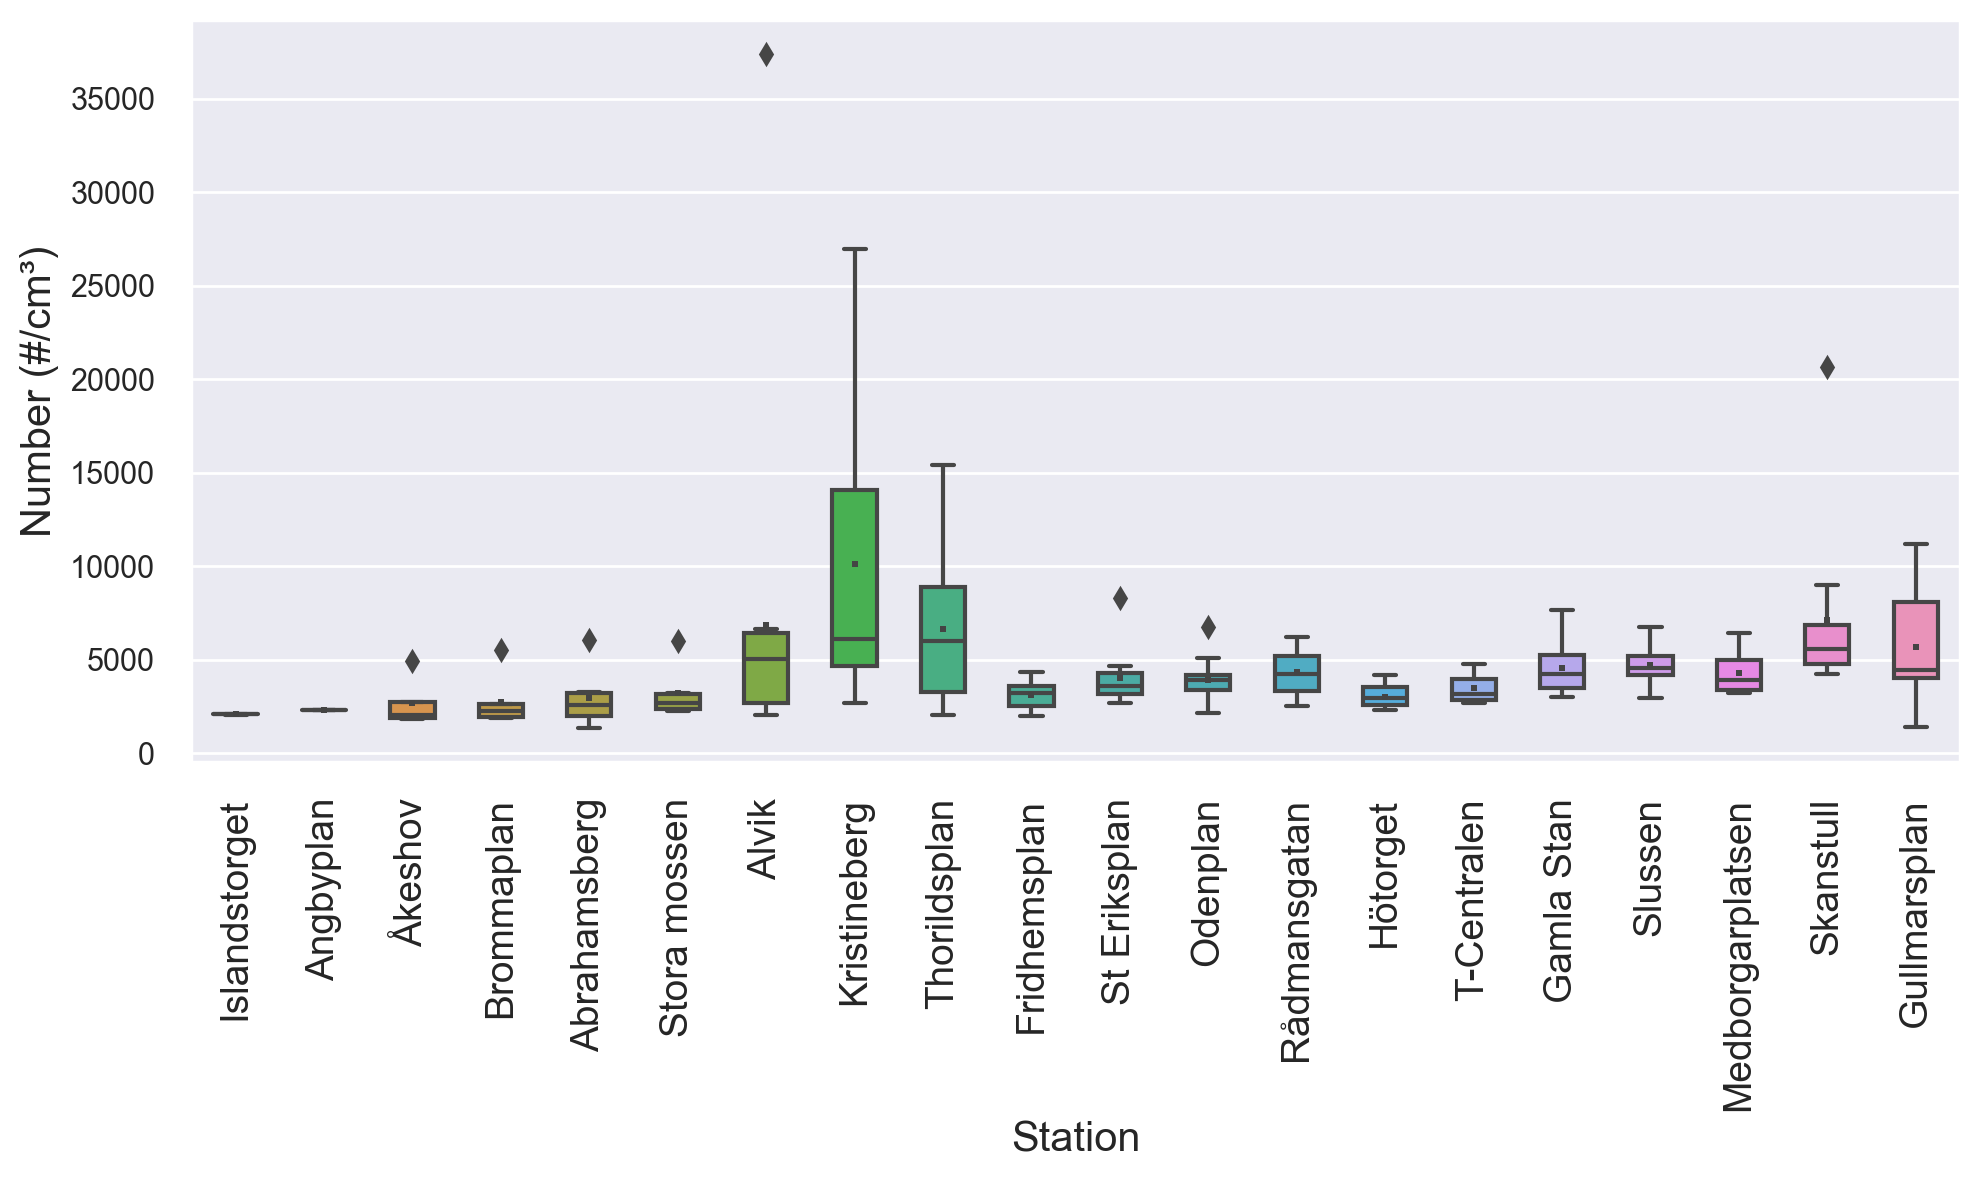

In [11]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line(), showmeans=True,
    #meanline=True, 
    meanprops={"marker": 's',
                "markerfacecolor":"#444", 
                "markersize":"2"
    })
plt.xticks(rotation=90, fontsize=14)
#plt.title('Box Plots Stations')
plt.ylabel(fr"{param} ({unit})", fontsize=15)
plt.xlabel(fr"Station", fontsize=15)
plt.tight_layout()
plt.savefig(f'{fig_folder}/box_plots({param}).pdf', dpi=300, bbox_inches="tight")
plt.show()

### Quantiles and outliers

In [13]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles.to_csv(f'{fig_folder}/tables/station_quantiles({param}).csv')
station_quantiles[param].sort_values(by='outliers', ascending=False)

Q1           Q2            Q3          IQR  \
Station                                                                 
Abrahamsberg      1983.250000  2596.722222   3210.861111  1227.611111   
Alvik             2709.500000  5014.857143   6412.857143  3703.357143   
Stora mossen      2378.750000  2707.166667   3178.369048   799.619048   
St Eriksplan      3145.000000  3610.538462   4292.800000  1147.800000   
Skanstull         4774.938697  5583.000000   6876.974359  2102.035662   
Odenplan          3363.389323  3913.539062   4180.297619   816.908296   
Åkeshov           1885.928571  2051.750000   2756.695652   870.767081   
Brommaplan        1926.100694  2257.871032   2622.409341   696.308646   
Hötorget          2580.452206  2945.525000   3531.666667   951.214461   
Islandstorget     2074.730769  2090.461538   2106.192308    31.461538   
Kristineberg      4683.666667  6111.200000  14104.100000  9420.433333   
Gullmarsplan      4018.944444  4467.000000   8085.850000  4066.905556   
Gamla Stan        3512.386364  4231.500000   5275.143433  1762.757070   
Rådmansgatan      3343.464286  4250.150000   5198.987500  1855.523214   
Fridhemsplan      2530.388889  3248.400000   3574.250000  1043.861111   
Slussen           4162.537879  4562.125000   5203.259050  1040.721171   
Angbyplan         2292.000000  2292.000000   2292.000000     0.000000   
T-Centralen       2831.522727  3180.721429   3994.979167  1163.456439   
Thorildsplan      3296.649351  5979.400000   8875.166667  5578.517316   
Medborgarplatsen  3379.708333  3918.117647   4973.377778  1593.669444   

                   lowerLimit    upperLimit  outliers  prcnt_outliers  count  
Station                                                                       
Abrahamsberg       141.833333   5052.277778       1.0       16.666667      6  
Alvik            -2845.535714  11967.892857       1.0        7.692308     13  
Stora mossen      1179.321429   4377.797619       1.0       16.666667      6  
St Eriksplan      1423.300000   6014.500000       1.0        7.692308     13  
Skanstull         1621.885205  10030.027851       1.0        9.090909     11  
Odenplan          2138.026879   5405.660063       1.0        5.263158     19  
Åkeshov            579.777950   4062.846273       1.0       20.000000      5  
Brommaplan         881.637725   3666.872310       1.0       16.666667      6  
Hötorget          1153.630515   4958.488358       0.0        0.000000     12  
Islandstorget     2027.538462   2153.384615       0.0        0.000000      2  
Kristineberg     -9446.983333  28234.750000       0.0        0.000000     13  
Gullmarsplan     -2081.413889  14186.208333       0.0        0.000000     10  
Gamla Stan         868.250759   7919.279037       0.0        0.000000     11  
Rådmansgatan       560.179464   7982.272321       0.0        0.000000     12  
Fridhemsplan       964.597222   5140.041667       0.0        0.000000     13  
Slussen           2601.456122   6764.340806       0.0        0.000000     12  
Angbyplan         2292.000000   2292.000000       0.0        0.000000      1  
T-Centralen       1086.338068   5740.163826       0.0        0.000000     12  
Thorildsplan     -5071.126623  17242.942641       0.0        0.000000     11  
Medborgarplatsen   989.204167   7363.881944       0.0        0.000000     11

**Comment**

Some stations have outliers. What happened during these sessions?

In [14]:
outlier_ids = print_outliers(s_df, station_quantiles, param)

=== OUTLIERS ===
Abrahamsberg:
	20210929-2 - Number = 6061.82

Alvik:
	20211012-2 - Number = 37409.23

Brommaplan:
	20210929-2 - Number = 5542.25

Odenplan:
	20211001-3 - Number = 6776.25

Skanstull:
	20211005-1 - Number = 20668.6

St Eriksplan:
	20211001-3 - Number = 8289.5

Stora mossen:
	20210929-2 - Number = 5996.58

Åkeshov:
	20210929-2 - Number = 4937.0

Unique outliers: ['20210929-2', '20211001-3', '20211005-1', '20211012-2']


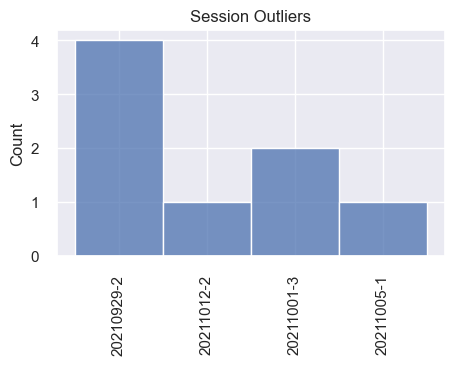

In [15]:
fig, ax = plt.subplots(figsize=[5, 3], dpi=100)

sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

In [20]:
param = 'Number'

s_id = '20211005-1'

tmp1 = s_df[s_df['Session Id'] == s_id][['Station', param]]

tmp2 = s_df.groupby('Station').agg({param: 'mean'})[param][list(tmp1.Station.unique())]
tmp2 = tmp2.to_frame()

tmp2['Station'] = tmp2.index
tmp2 = tmp2.reset_index(drop=True)

tmp2 = tmp2.rename(columns={param: f'{param} Mean'})

tmp = pd.merge(tmp1, tmp2, on='Station')

tmp['Diff'] = tmp[param] - tmp[f'{param} Mean']

print(get_middle_value(s_df[s_df['Session Id'] == s_id], 'Timestamp'))

tmp

2021-10-05 07:25:44


Station        Number   Number Mean          Diff
0              Alvik   5279.833333   6875.923983  -1596.090650
1       Kristineberg  26939.800000  10104.999328  16834.800672
2       Thorildsplan   5979.400000   6670.216971   -690.816971
3       Fridhemsplan   3342.200000   3093.807937    248.392063
4       St Eriksplan   4687.833333   4010.105420    677.727913
5           Odenplan   4019.500000   3907.584162    111.915838
6       Rådmansgatan   4649.200000   4328.124028    321.075972
7           Hötorget   3182.250000   3033.433582    148.816418
8        T-Centralen   3630.928571   3474.405613    156.522958
9         Gamla Stan   3328.272727   4538.548243  -1210.275516
10           Slussen   2939.625000   4744.295432  -1804.670432
11  Medborgarplatsen   3196.470588   4271.632474  -1075.161886
12         Skanstull  20668.600000   7118.694390  13549.905610
13      Gullmarsplan   4688.000000   5701.800011  -1013.800011

## Rush and off hours

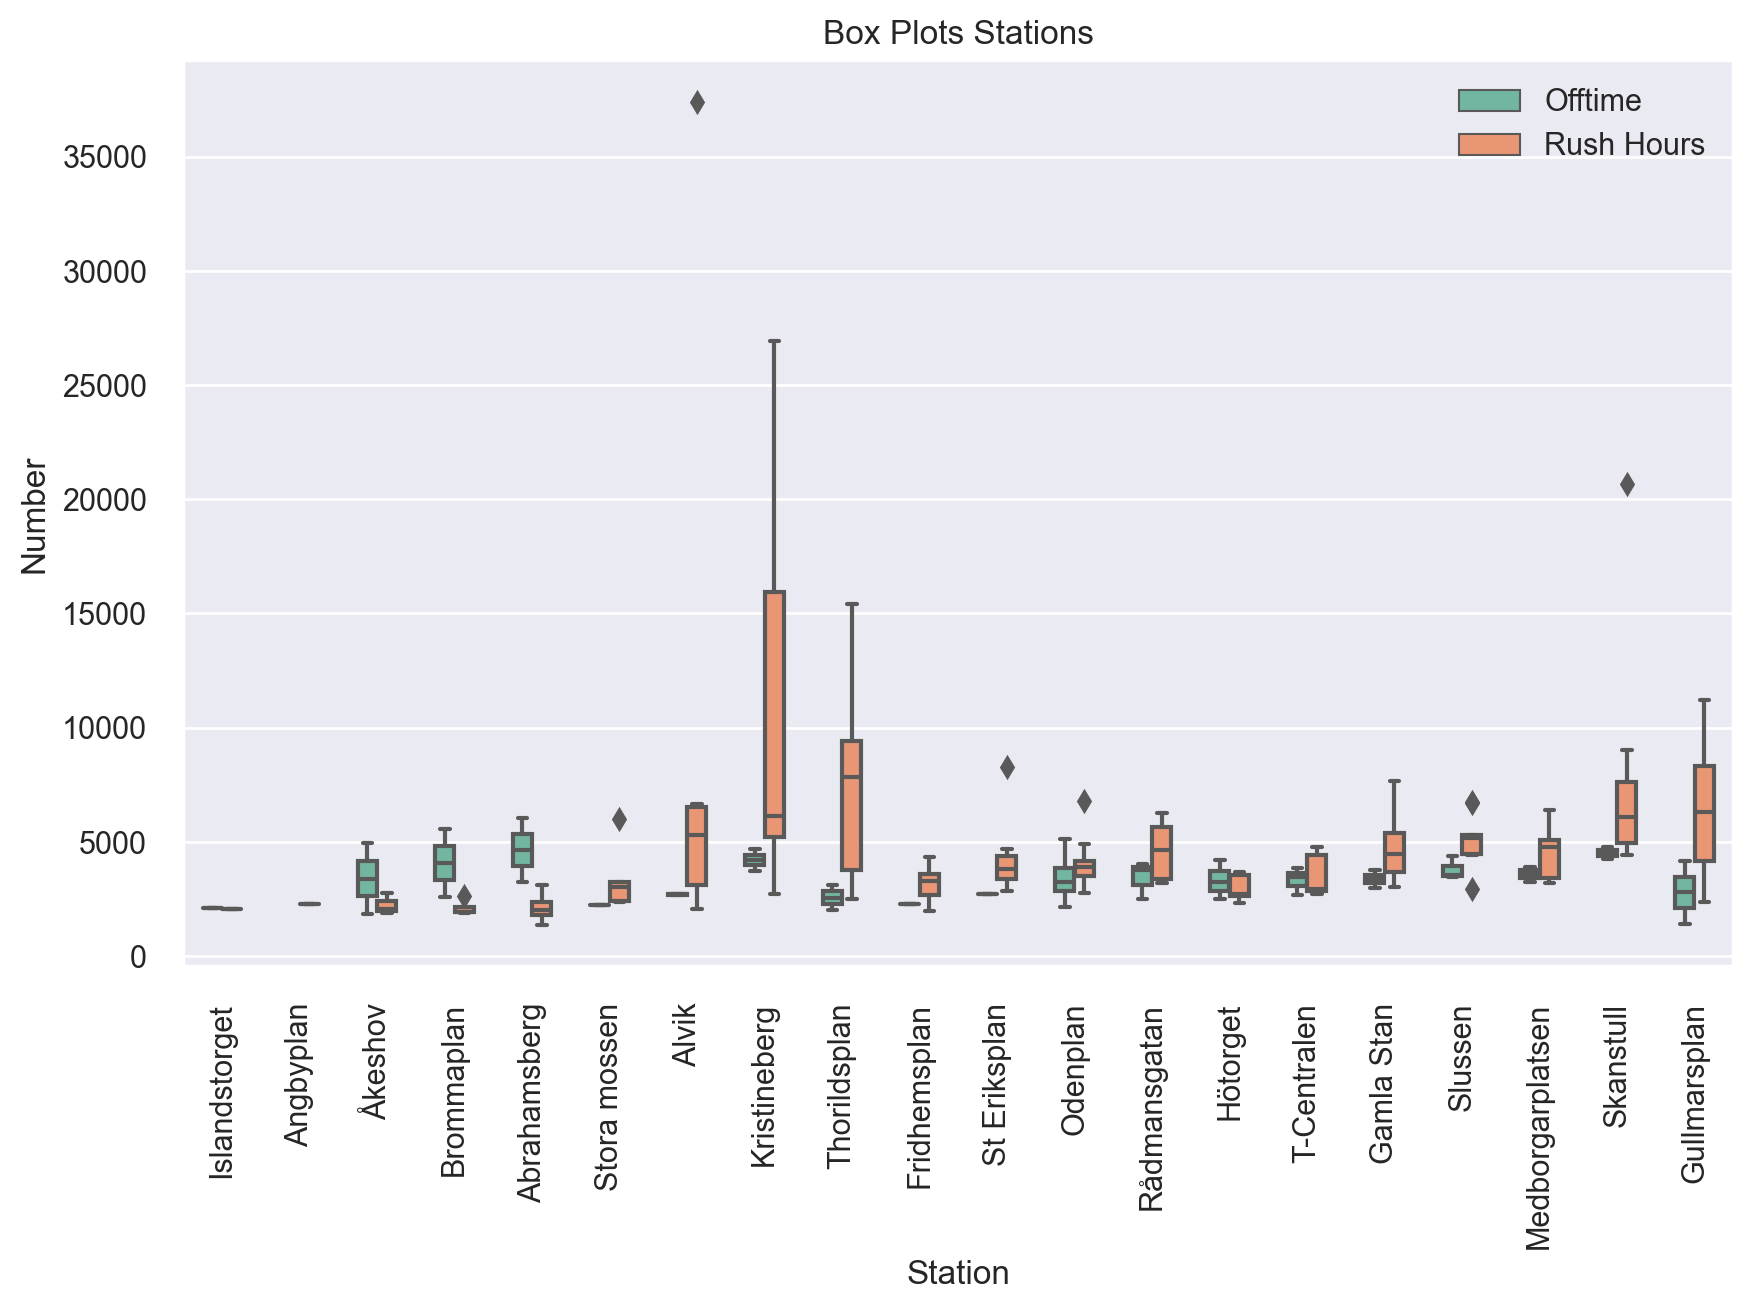

In [21]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.copy()
plot_df['Period'] = plot_df['Period'].apply(lambda x: 'Rush Hours' if x in ['Evening rush', 'Morning rush'] else x)

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_rush_vs_offtime({param}).pdf')

plt.show()

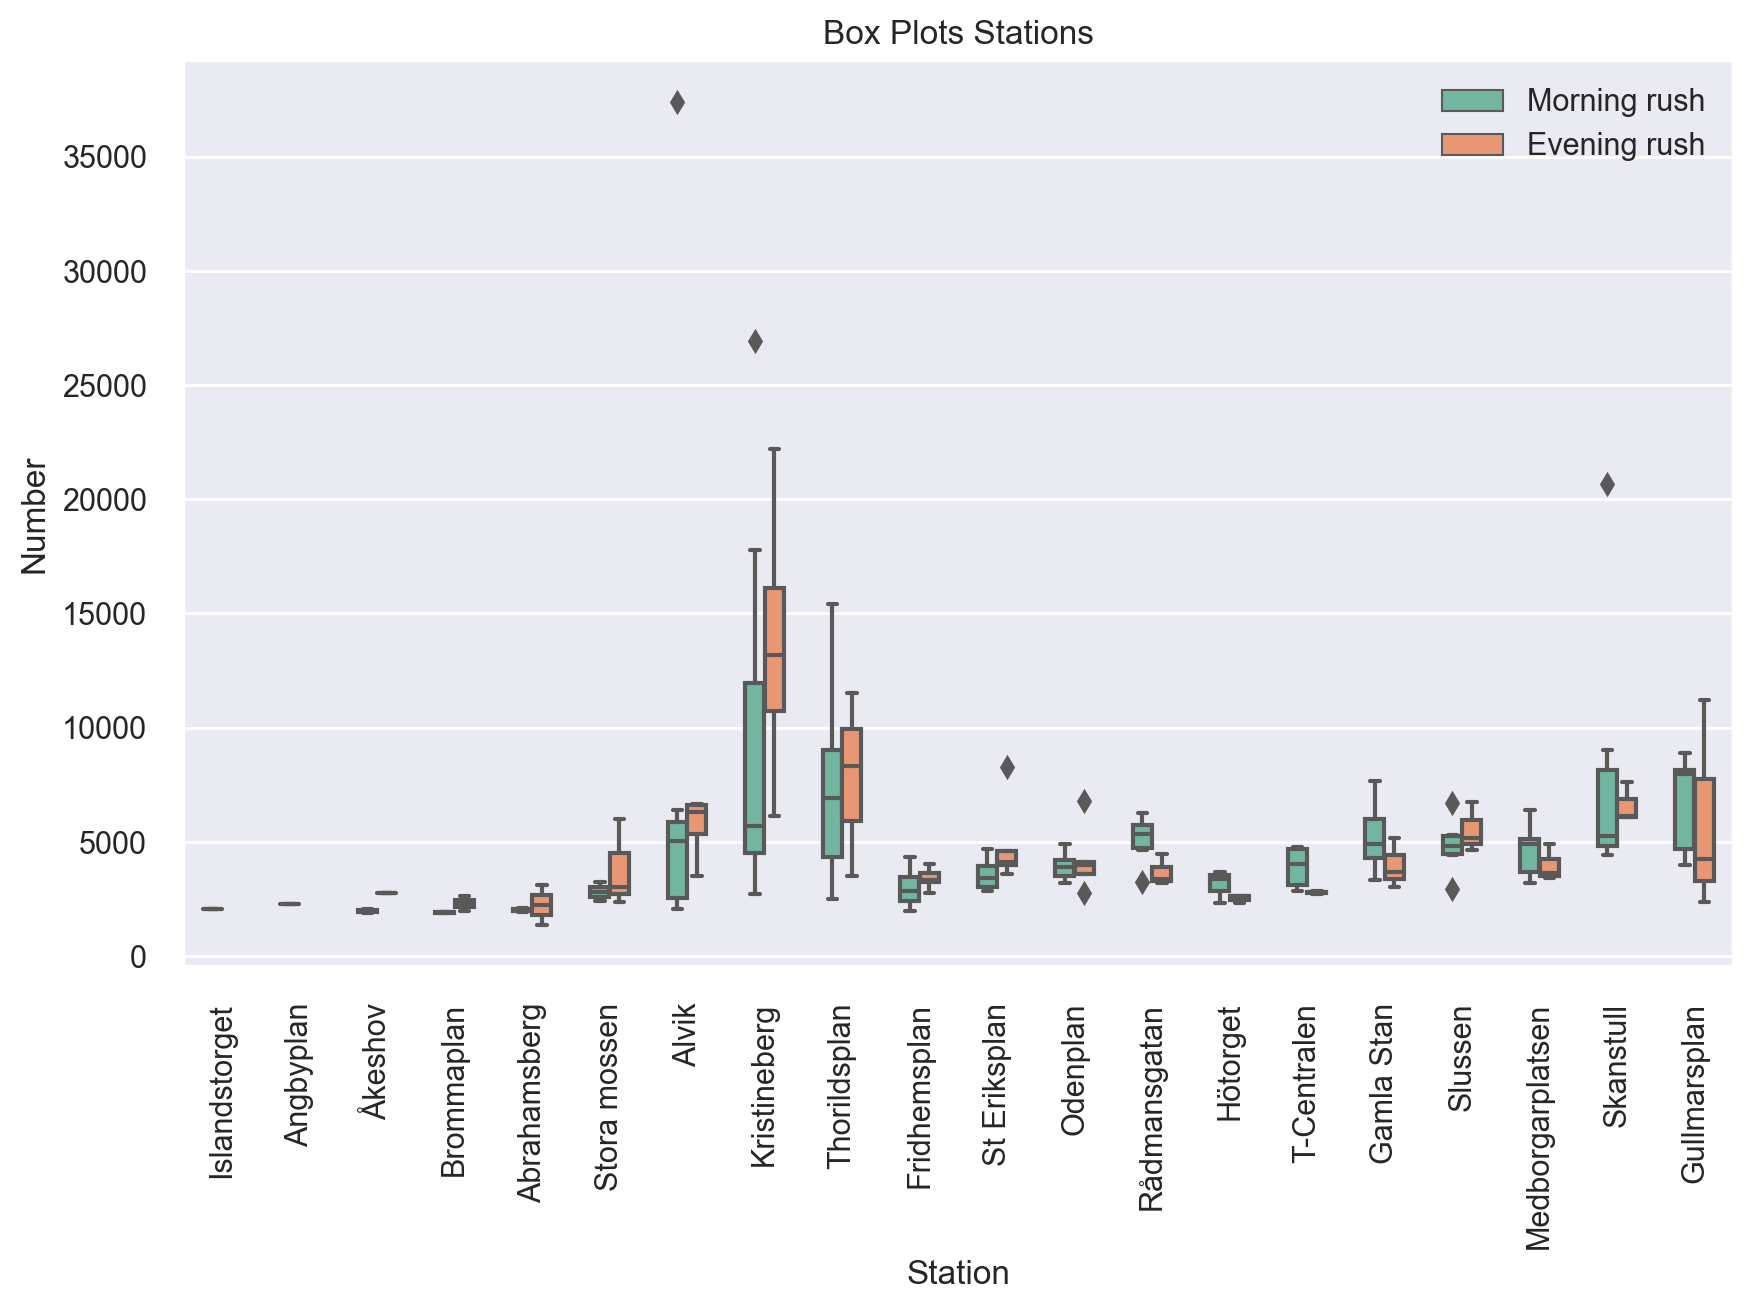

In [22]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.loc[s_df['Period'] != 'Offtime']

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_morning_evening_rush({param}).pdf')

plt.show()

### Histograms

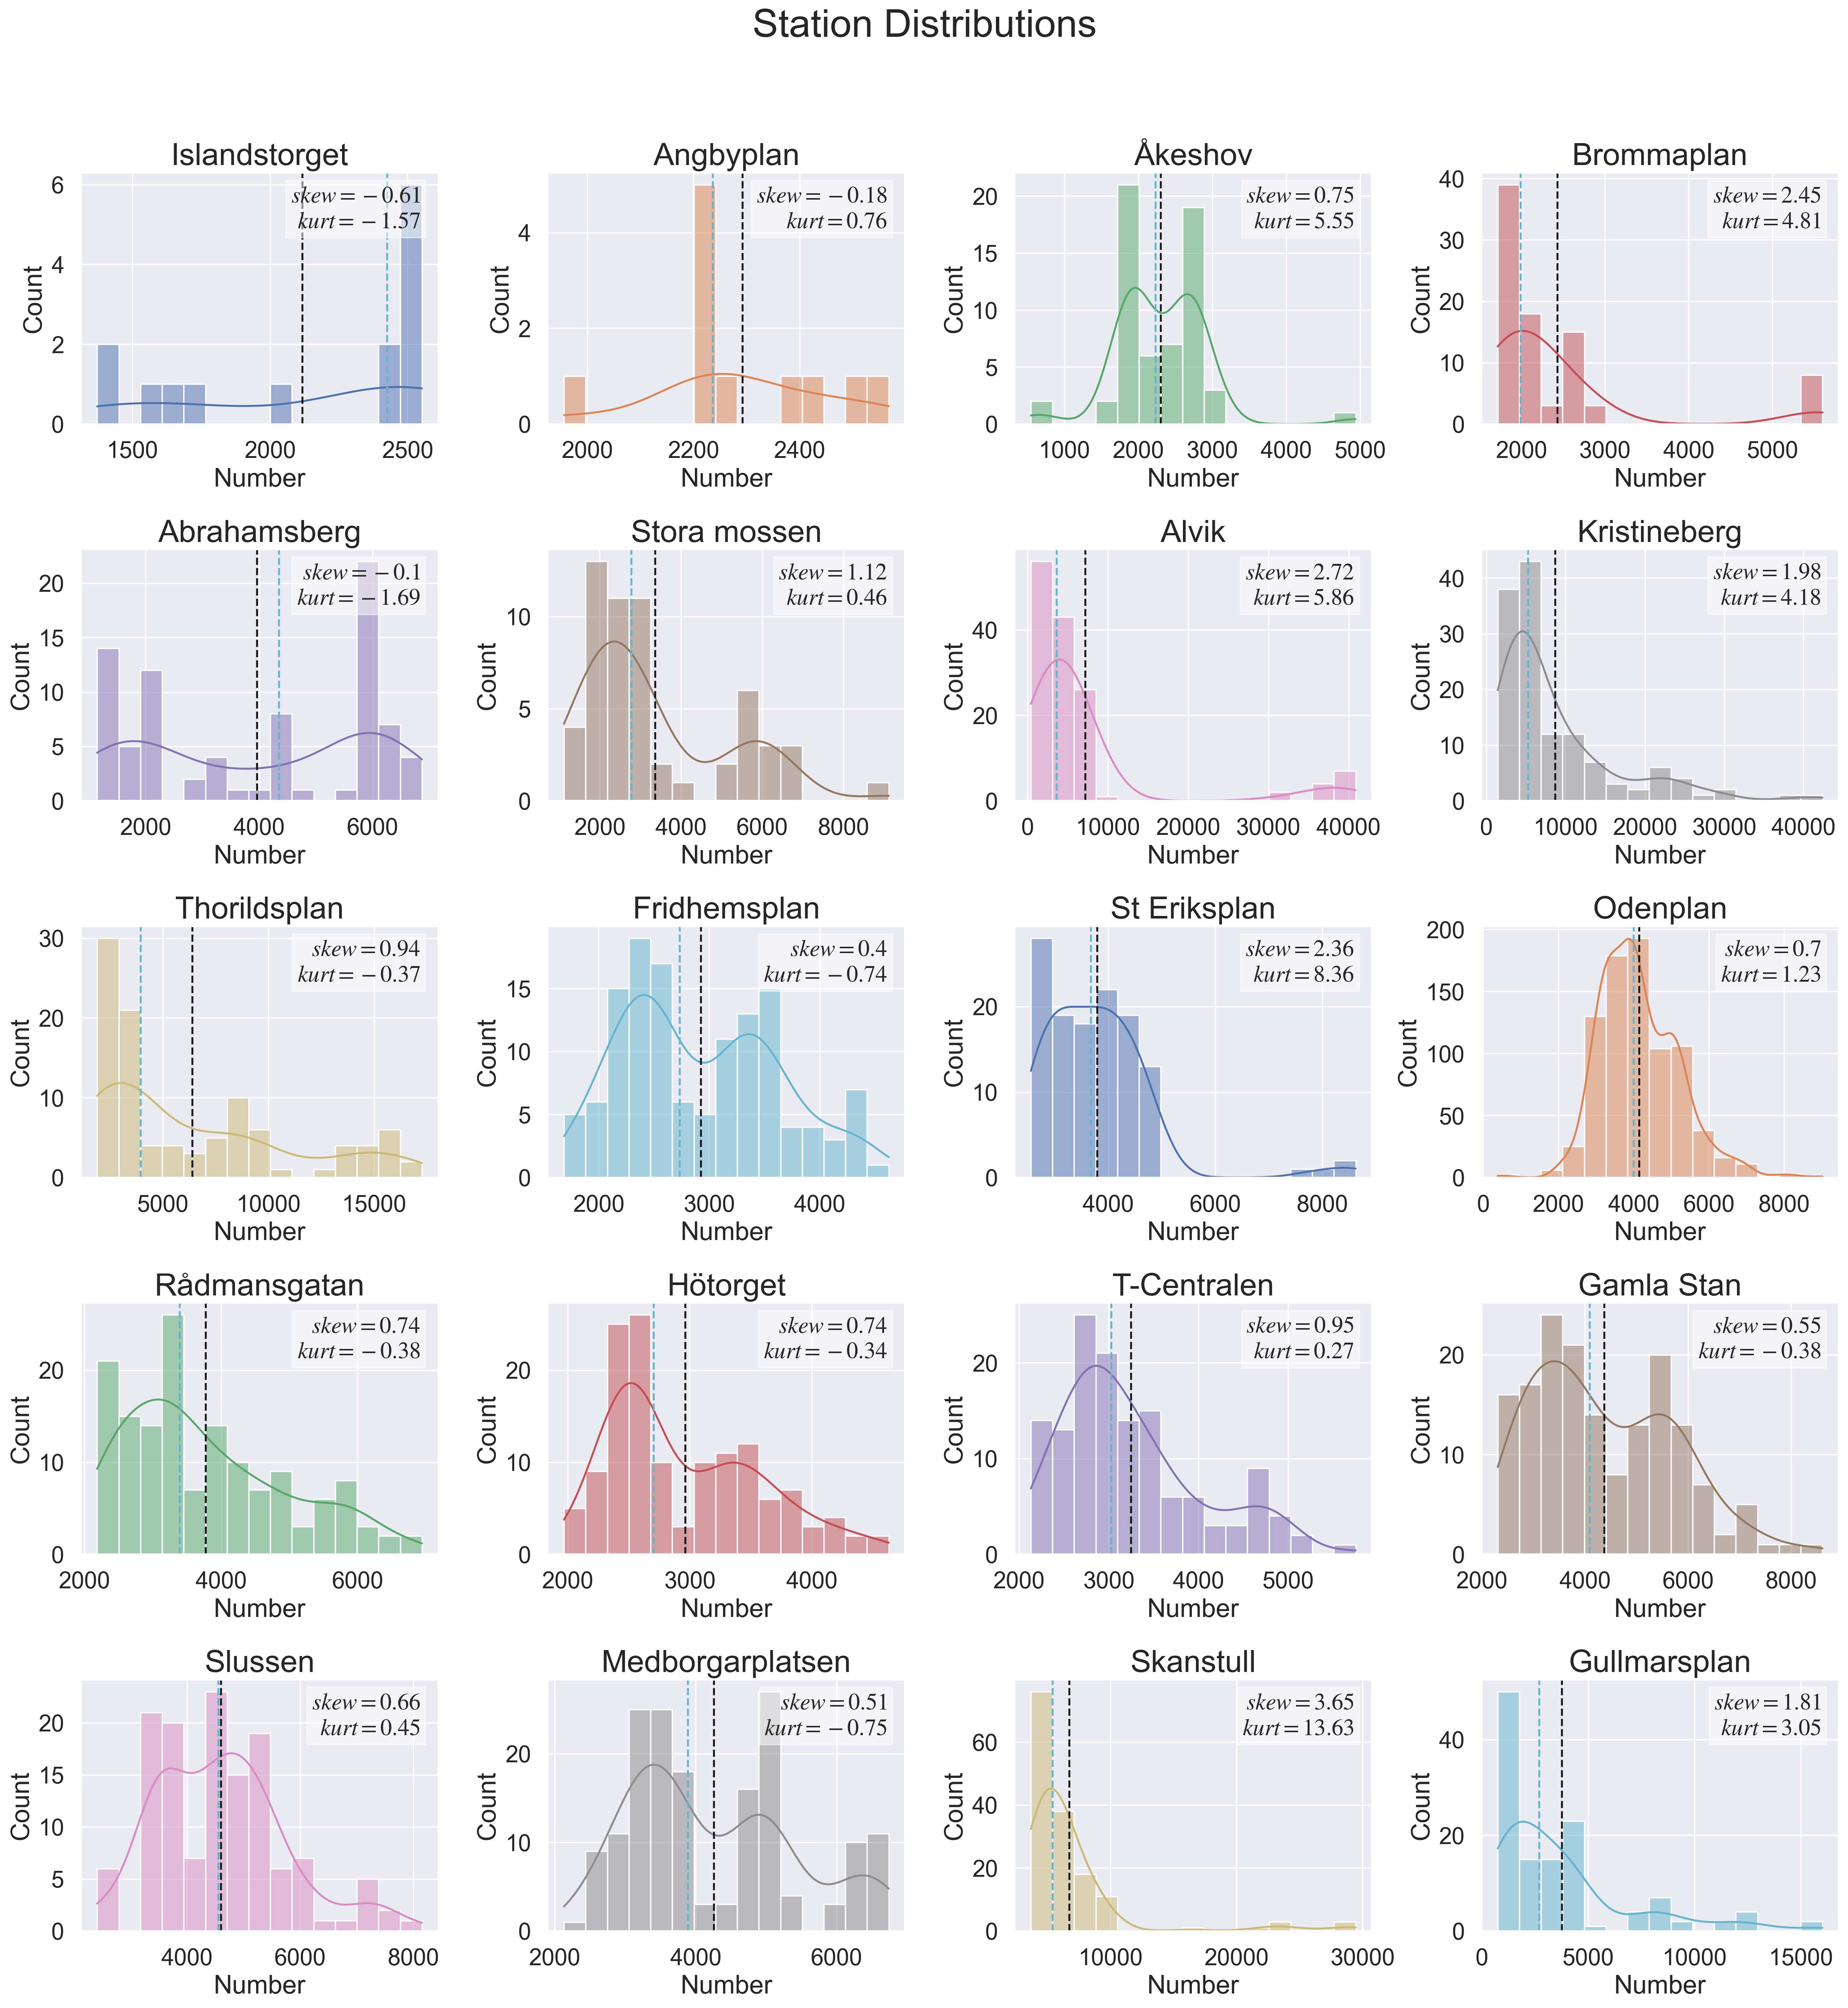

In [23]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/distributions({param}).pdf',
    param=param,
    with_textbox=True,
    column_count=4,
    bins=15
)

### Normal distribution

In [24]:
normal = r_df.groupby('Station').agg({param: [skew, kurtosis]})
normal[param].to_csv(f'{fig_folder}/tables/normal({param}).csv')

normal

Number           
                      skew   kurtosis
Station                              
Abrahamsberg     -0.097132  -1.692824
Alvik             2.718034   5.855927
Angbyplan        -0.179674   0.758497
Brommaplan        2.447037   4.808506
Fridhemsplan      0.398504  -0.736896
Gamla Stan        0.547618  -0.378318
Gullmarsplan      1.813772   3.054801
Hötorget          0.740249  -0.335916
Islandstorget    -0.613254  -1.570417
Kristineberg      1.984585   4.176146
Medborgarplatsen  0.514621  -0.748796
Odenplan          0.702476   1.228640
Rådmansgatan      0.744329  -0.376360
Skanstull         3.648252  13.627220
Slussen           0.658348   0.451434
St Eriksplan      2.361685   8.358439
Stora mossen      1.116313   0.463345
T-Centralen       0.954893   0.271147
Thorildsplan      0.941443  -0.373475
Åkeshov           0.752575   5.552646

#### QQ Plots

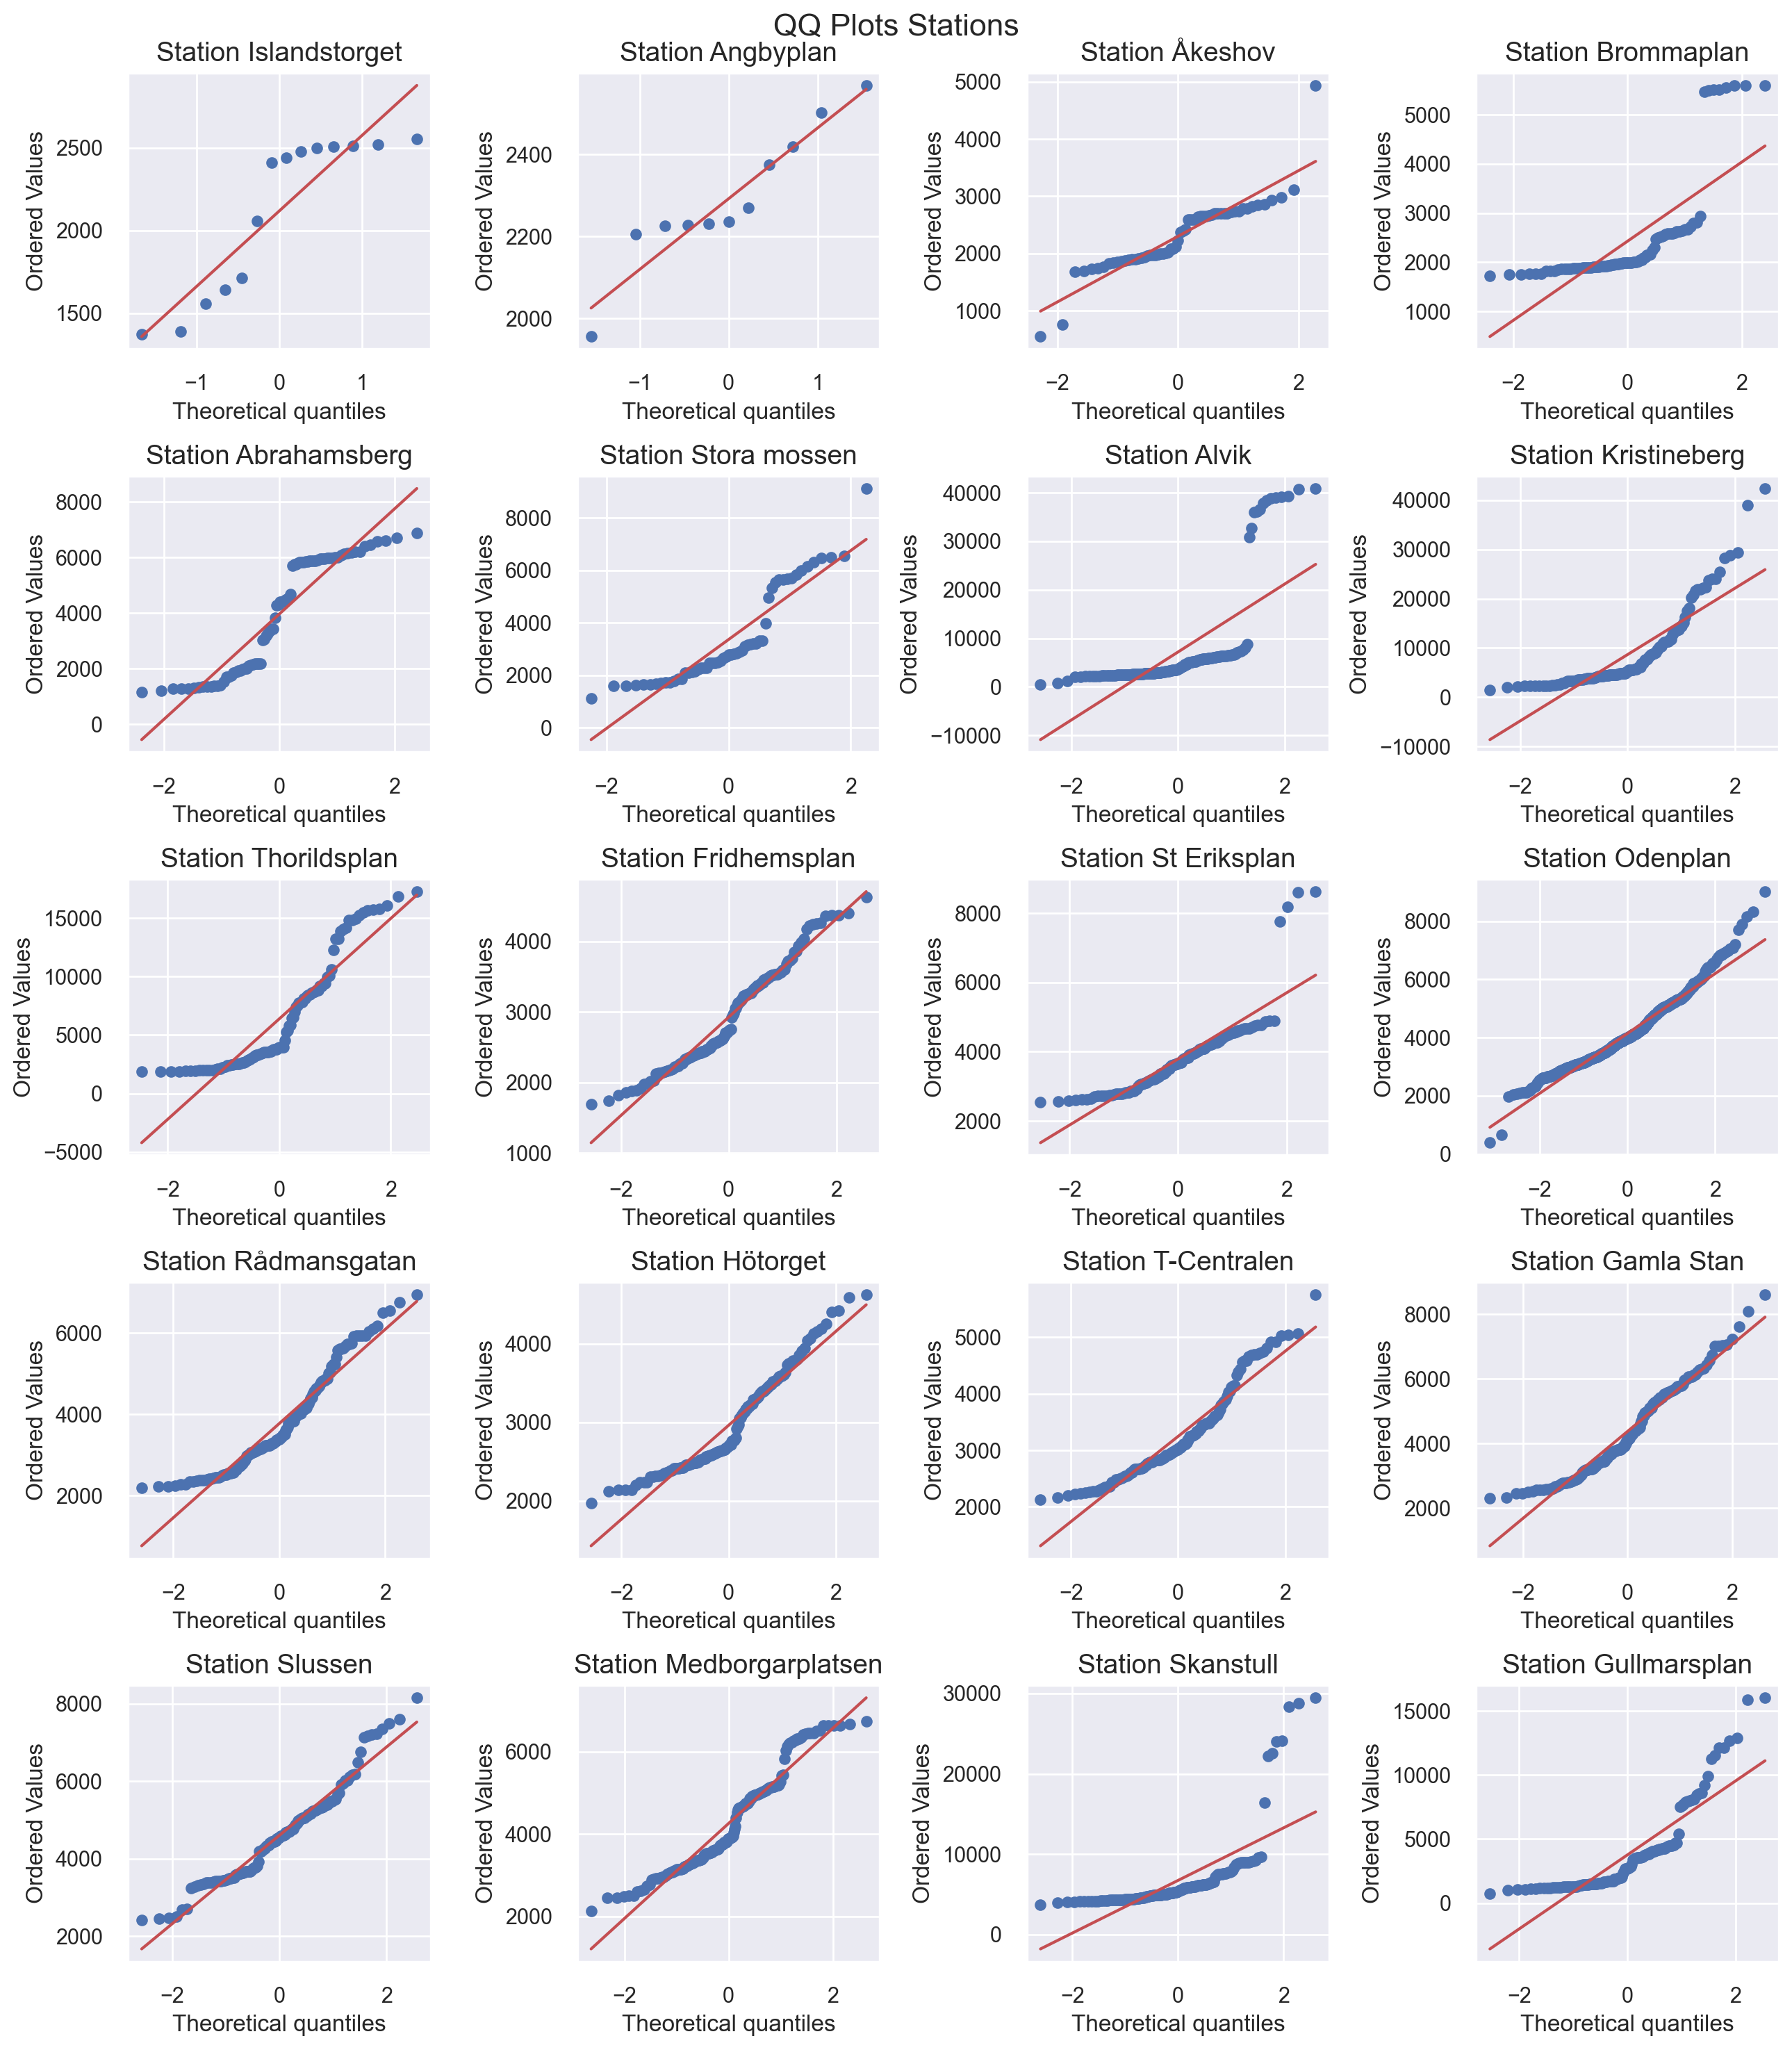

In [25]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

### Sensor diffs

How much do the sensor means per session per station differ? Compute standard deviation per session per station.

In [26]:
station_diffs = {}

for session_id, grp in r_df.groupby('Session Id'):
    for station, station_grp in grp.groupby('Station'):
        if station not in station_diffs:
            station_diffs[station] = []
            
        # Compute std
        station_diffs[station].append(sample_std(station_grp[param].values))
            
# Convert into one long array and make a histogram
station_diffs

mean_station_diffs = {s: np.nanmean(v) for s, v in station_diffs.items()}
mean_station_diffs

station_diffs_df = pd.DataFrame(list(mean_station_diffs.items()), columns=['station', 'mean sensor std'])
station_diffs_df['order'] = [get_green_line().index(station) for station in mean_station_diffs.keys()]

print(f'Total mean sensor diff: {station_diffs_df["mean sensor std"].mean()}')

station_diffs_df.to_csv(f'{fig_folder}/tables/sensors_diffs_per_station({param}).csv')

station_diffs_df.sort_values(by=['mean sensor std'], ascending=False)

Total mean sensor diff: 579.1595785938159


/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


station  mean sensor std  order
14      Kristineberg      3082.985589      7
6          Skanstull      1204.450968     18
16      Stora mossen       888.180852      5
17      Thorildsplan       872.717144      8
1       Gullmarsplan       784.821566     19
10             Alvik       713.551786      6
13     Islandstorget       492.660543      0
0         Gamla Stan       392.997680     15
4           Odenplan       386.711017     11
9       Abrahamsberg       380.116869      4
7            Slussen       374.599028     16
18           Åkeshov       346.422982      2
8        T-Centralen       301.853342     14
5       Rådmansgatan       263.578568     12
3   Medborgarplatsen       255.090196     17
2           Hötorget       223.795197     13
15      St Eriksplan       181.594831     10
19         Angbyplan       166.947896      1
12      Fridhemsplan       165.080414      9
11        Brommaplan       105.035105      3

### How much do every single sensor differ per station?

In [27]:
diffs = {}

for station, grp in r_df.groupby('Station'):
    diffs[station] = {}
    for sensor, sensor_grp in grp.groupby('Sensor'):
        diffs[station][sensor] = sample_std(sensor_grp[param].values)

diffs_df = pd.concat([pd.DataFrame(diffs[s].values(), index=diffs[s].keys(), columns=[s]).T for s in r_df['Station'].unique()])

diffs_df.loc['Avg'] = diffs_df.mean()

diffs_df.to_csv(f'{fig_folder}/tables/sensor_diff_per_station({param}).csv')

diffs_df

DiSC
Islandstorget      473.631586
Angbyplan          166.947896
Åkeshov            610.881784
Brommaplan        1048.381270
Abrahamsberg      1995.967103
Stora mossen      1793.962090
Alvik             9924.446774
Kristineberg      7681.182722
Thorildsplan      4598.037794
Fridhemsplan       701.780506
St Eriksplan      1071.244122
Odenplan          1042.808196
Rådmansgatan      1187.410795
Hötorget           614.693143
T-Centralen        775.845452
Gamla Stan        1361.368957
Slussen           1152.365302
Medborgarplatsen  1180.540355
Skanstull         4551.275901
Gullmarsplan      3262.301447
Avg               2259.753660

# Focus on Kristineberg

In [28]:
focus_s_df = s_df.loc[s_df.Station == 'Kristineberg'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Kristineberg'].sort_values(by=['Sensor'])

### Box plots sensors

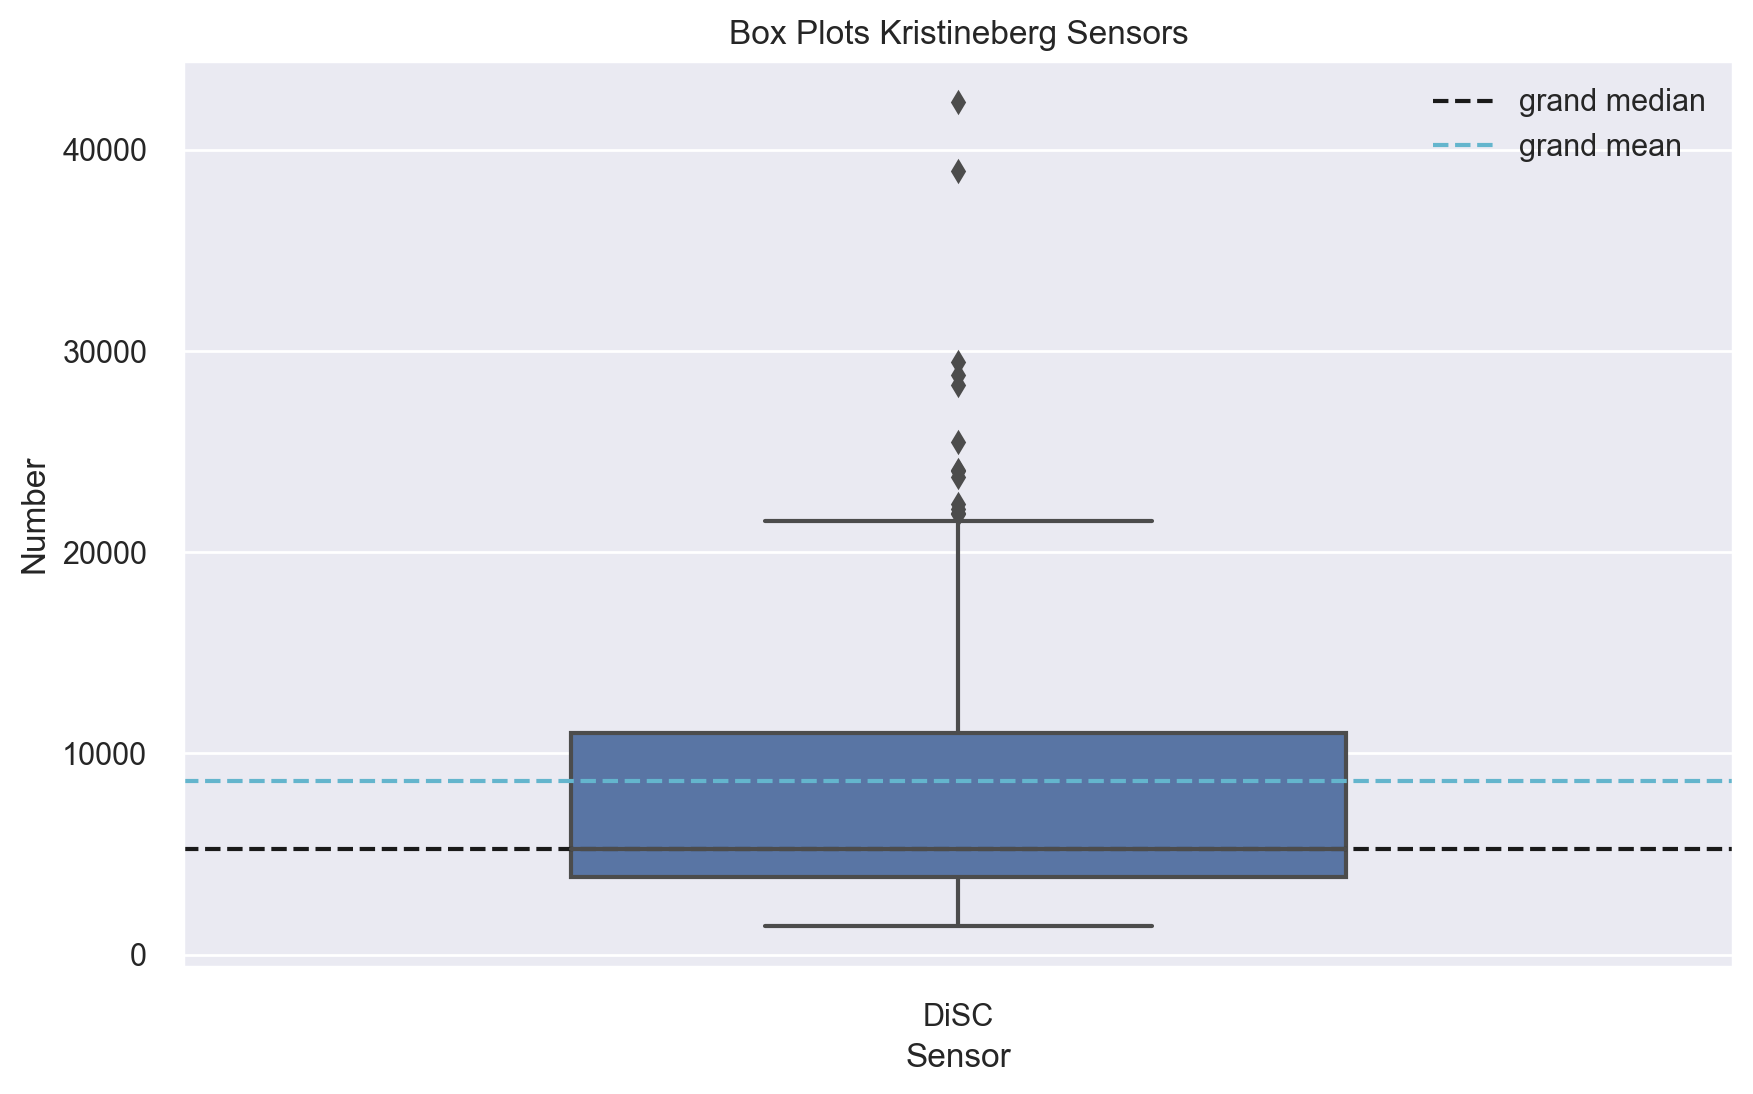

In [29]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Kristineberg Sensors')
plt.savefig(f'{fig_folder}/Kristineberg_box_plot_sensor({param}).pdf')
plt.show()

In [30]:
station_diffs['Kristineberg']

[1413.1200703879813,
 2469.4084480566057,
 724.7869903072774,
 5168.464458873385,
 1438.2590266630616,
 4341.0147579306185,
 5442.550677557148,
 2659.3792884806785,
 2370.55782464803,
 12354.2182341813,
 272.9253838533806,
 1223.1230518635482,
 201.00444202625403]

In [31]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

Number                                                          \
            Q1    Q2        Q3      IQR lowerLimit upperLimit outliers   
Sensor                                                                   
DiSC    3848.5  5241  11013.75  7165.25  -6899.375  21761.625       13   

                             
       prcnt_outliers count  
Sensor                       
DiSC         9.848485   132

### Box plot sessions

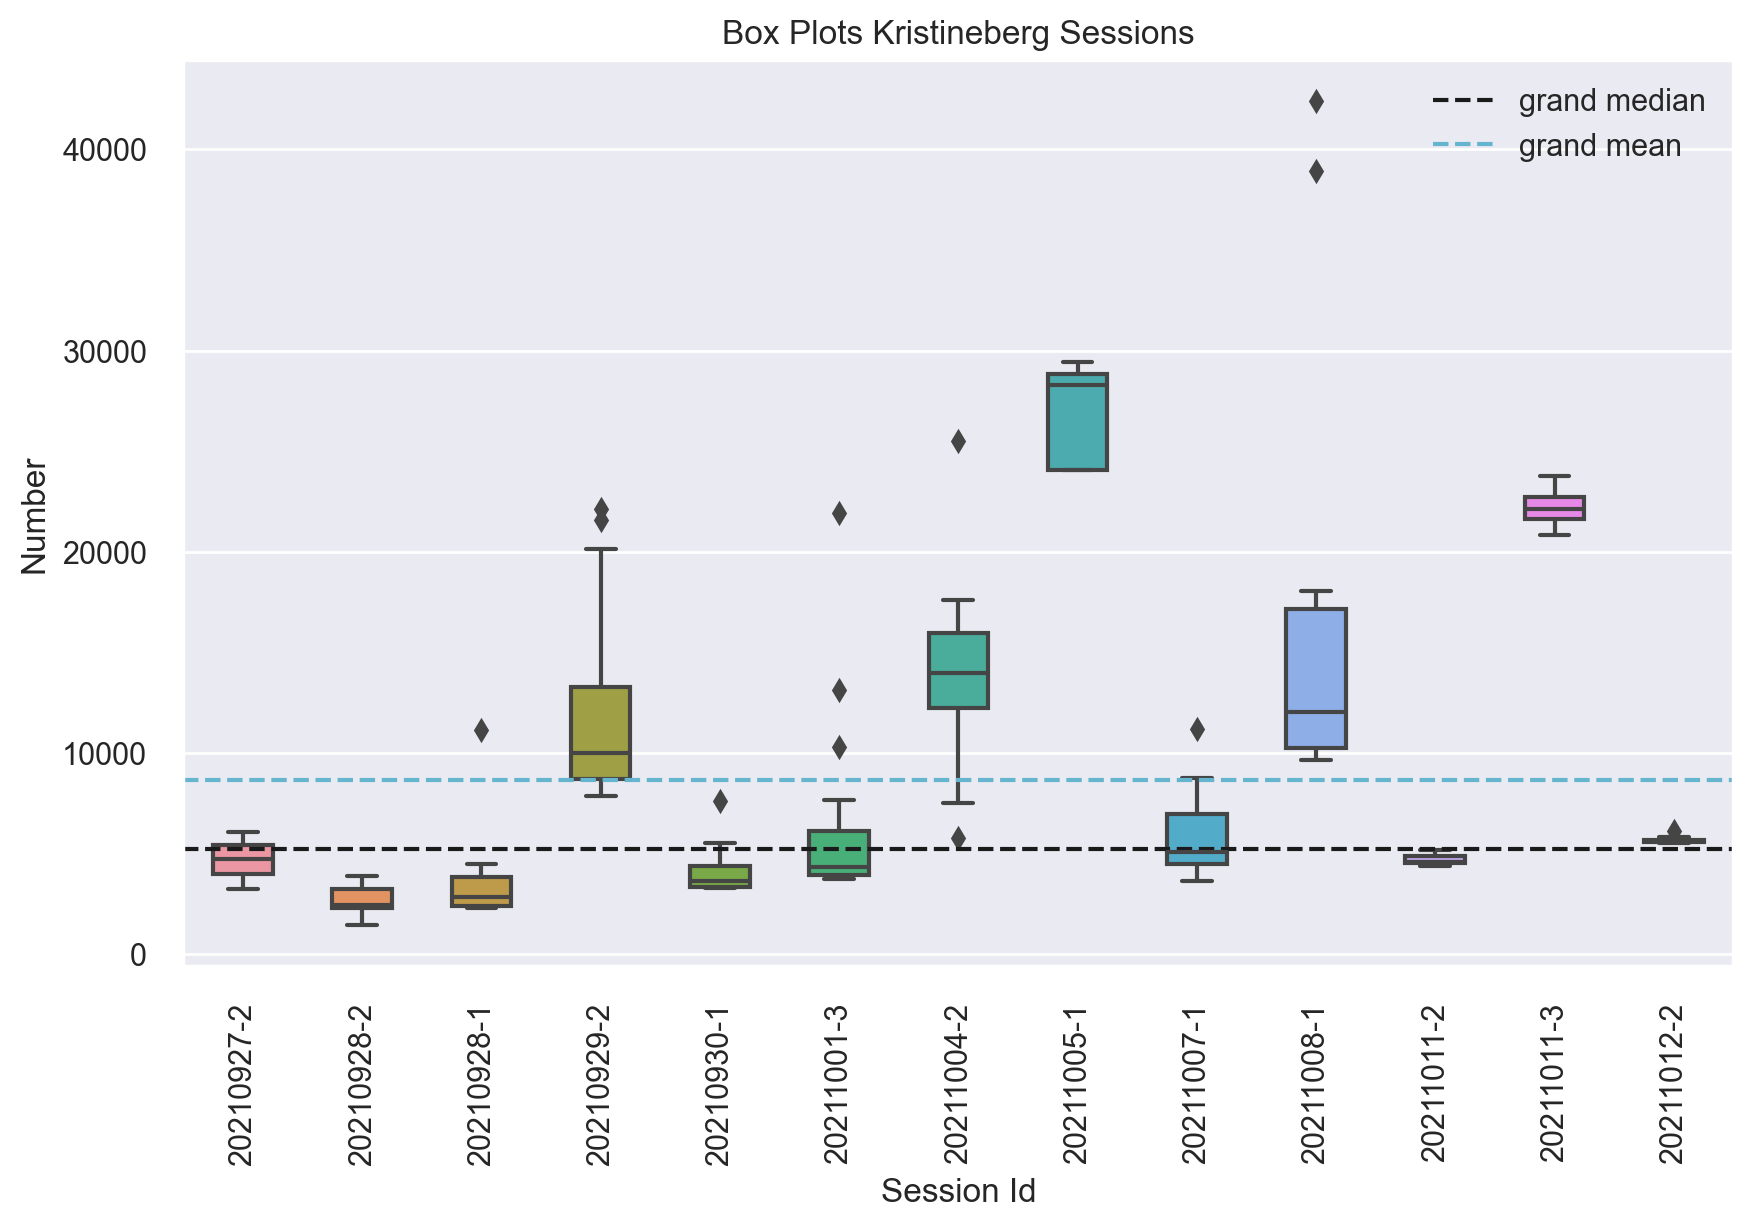

In [32]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Kristineberg Sessions')
plt.savefig(f'{fig_folder}/Kristineberg_box_plot_sessions({param}).pdf')
plt.show()

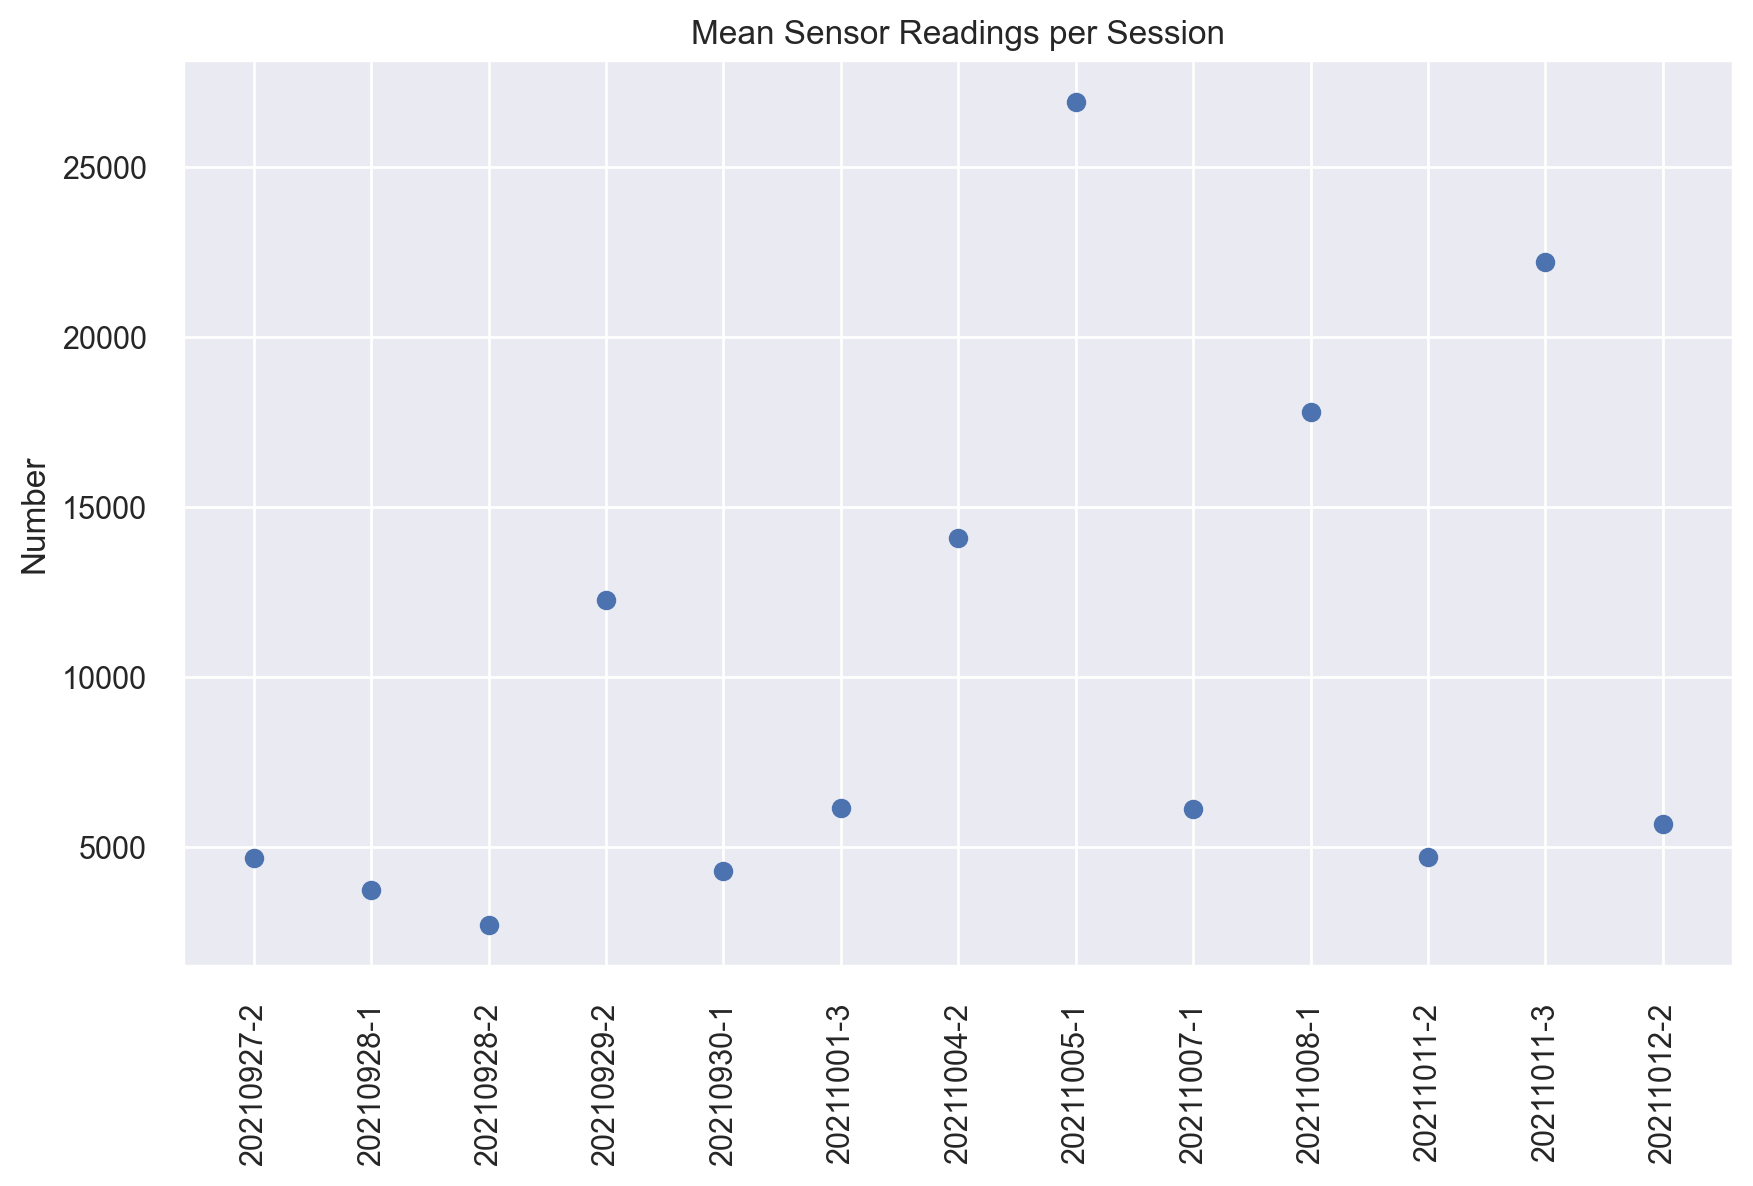

In [33]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

session_sensors = {}
for sensor, grp in focus_r_df.groupby('Sensor'):
    if sensor not in session_sensors:
        session_sensors[sensor] = {}
        
    for session_id, session_grp in grp.groupby('Session Id'):
        session_sensors[sensor][session_id] = session_grp[param].mean()
        
for sensor, data in session_sensors.items():
    ax.scatter(data.keys(), data.values(), label=sensor)
    
plt.xticks(rotation=90)
#plt.legend()
plt.title('Mean Sensor Readings per Session')
plt.savefig(f'{fig_folder}/Kristineberg_mean_sensor_reading_per_session({param}).pdf')
plt.ylabel(param)

plt.show()

### Distribution

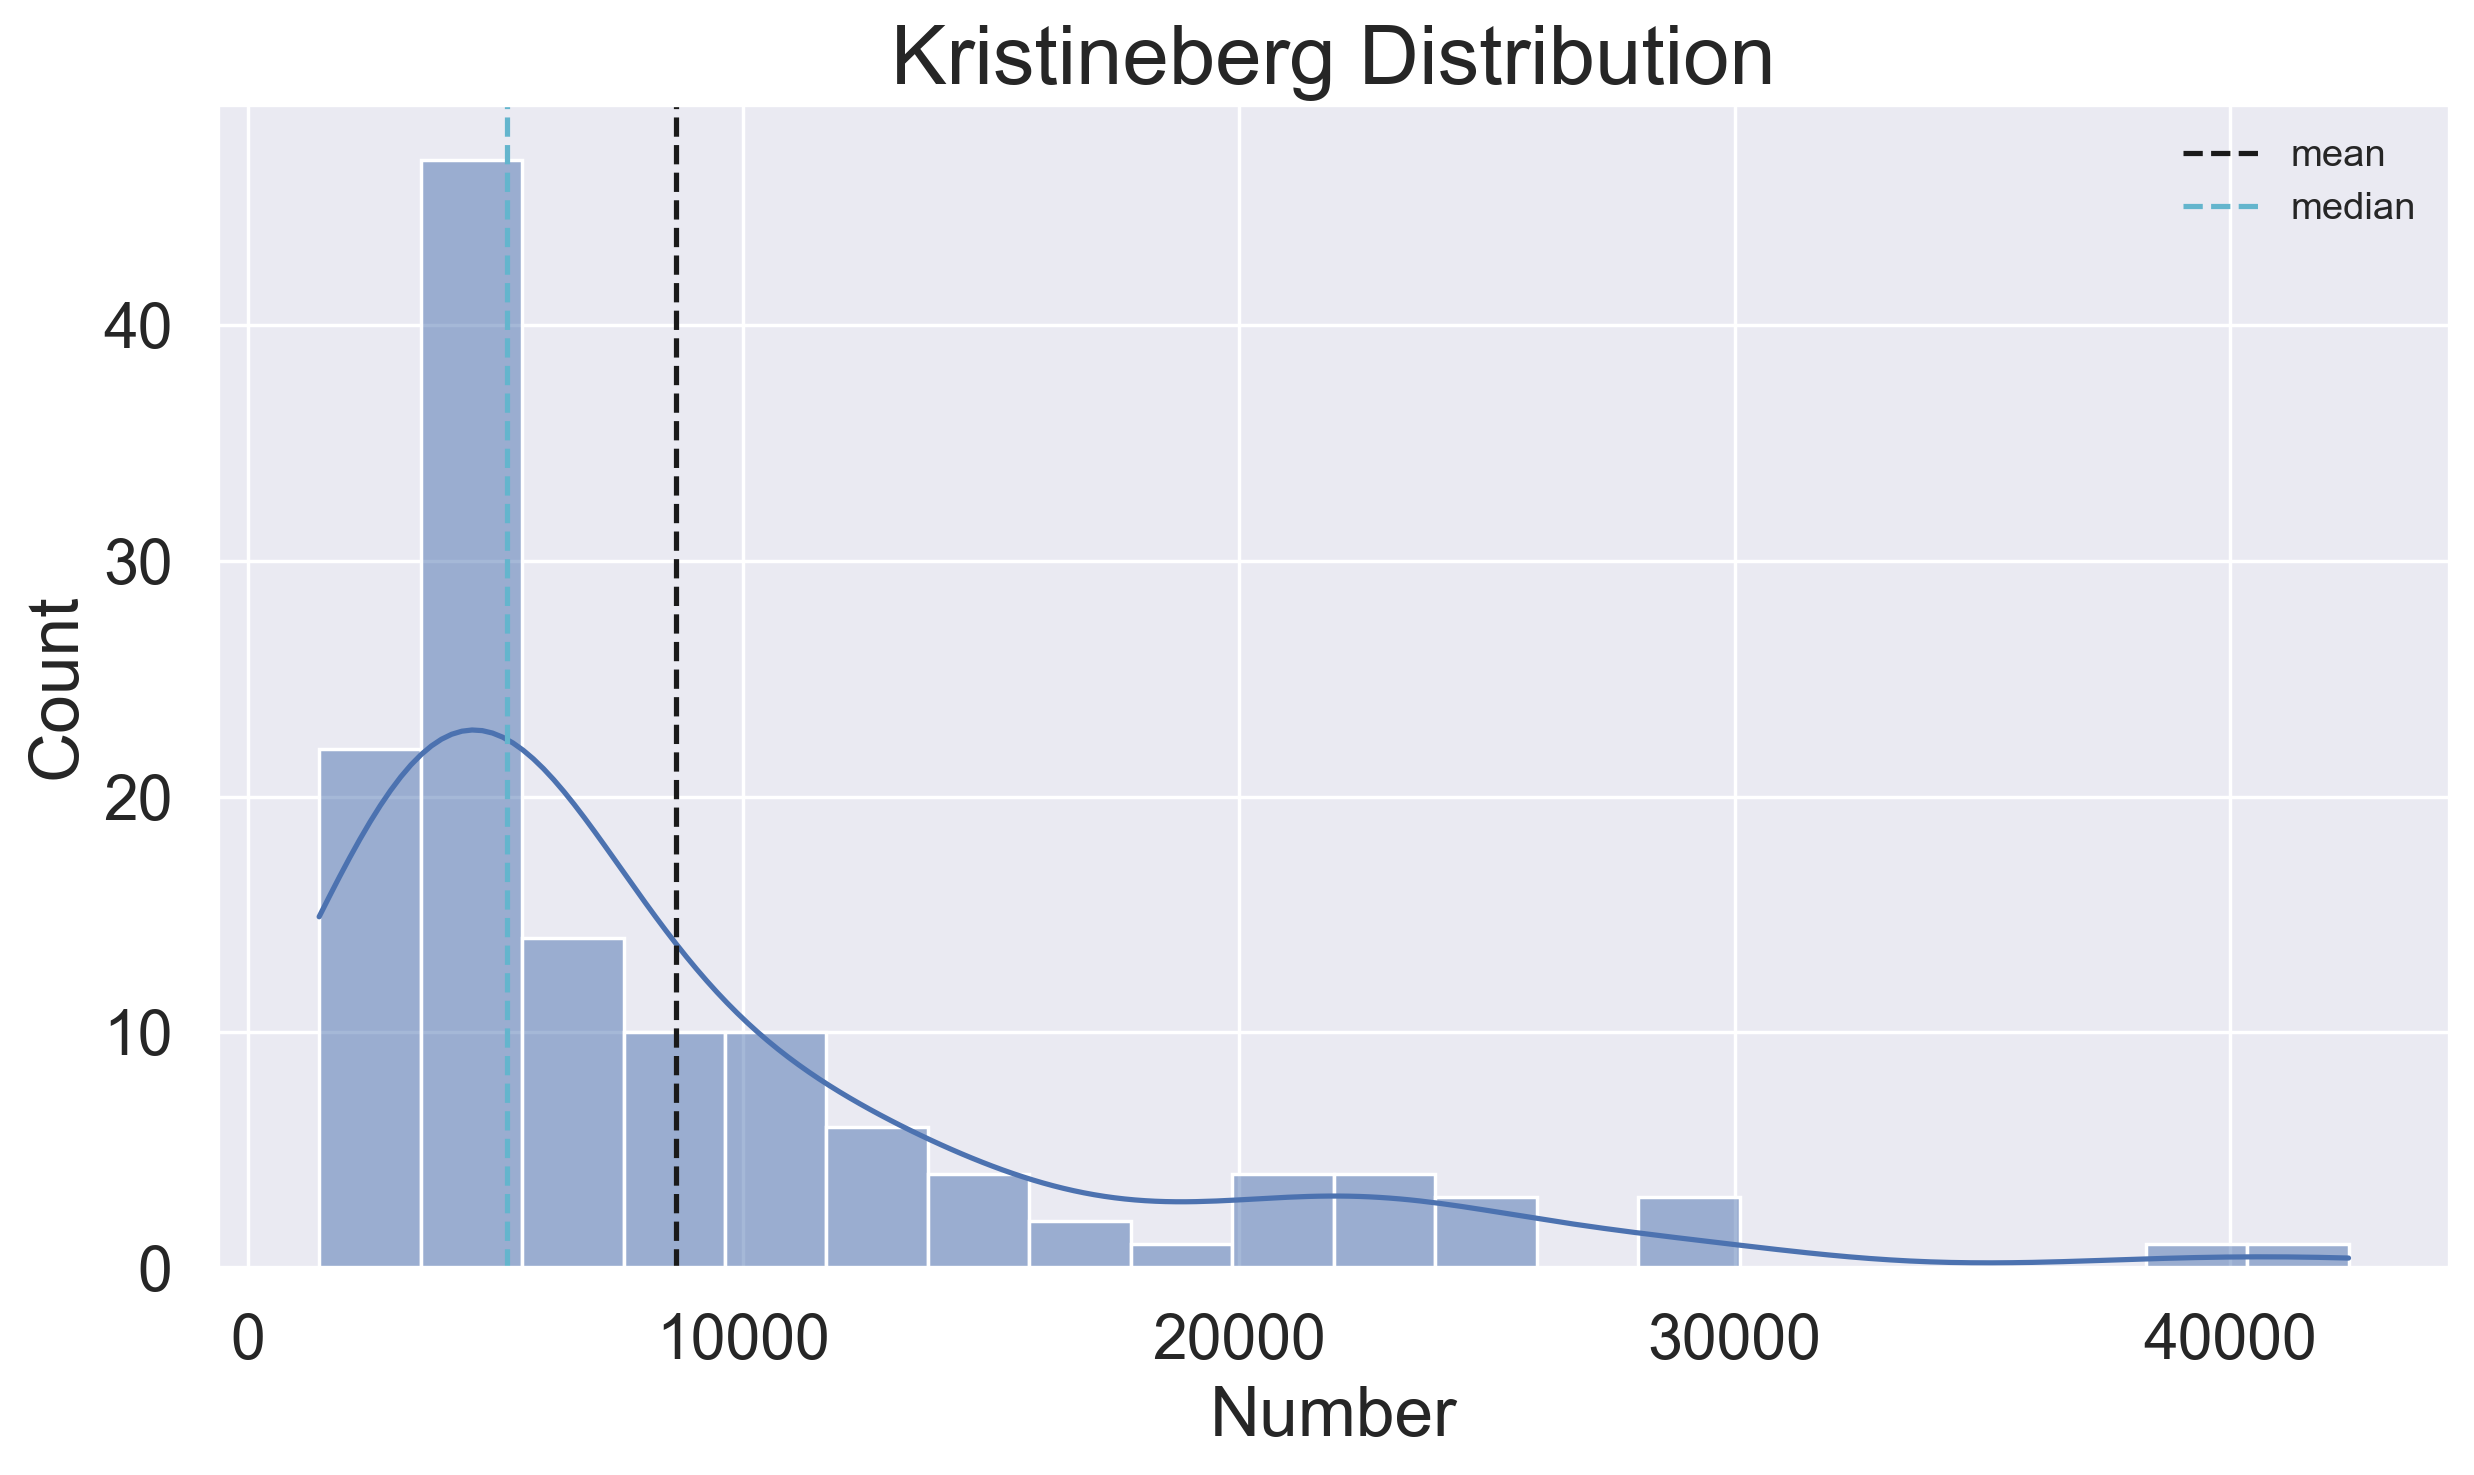

In [34]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=20)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Kristineberg Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/KristinebergDistribution({param}).pdf')

plt.show()

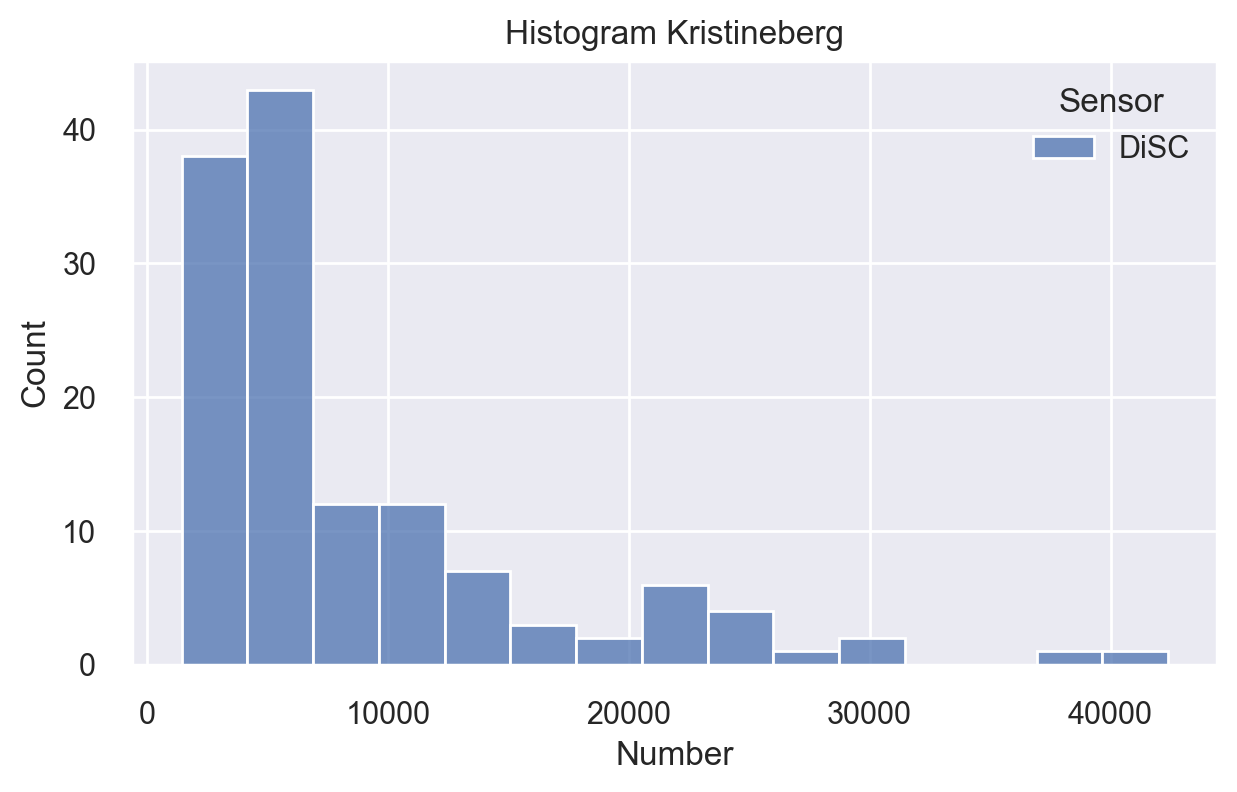

In [35]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Kristineberg')

plt.savefig(f'{fig_folder}/KristinebergHistogram1Sensor({param}).pdf')

plt.show()

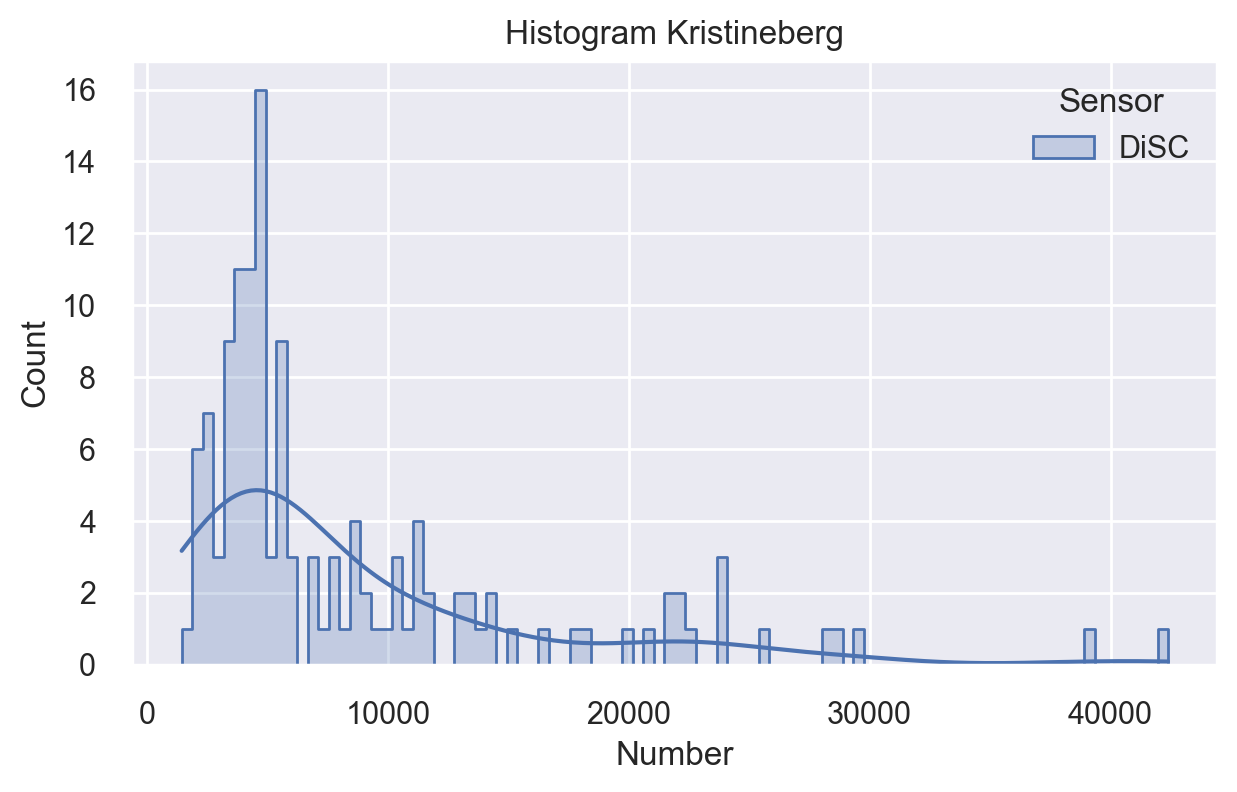

In [36]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Kristineberg')

plt.savefig(f'{fig_folder}/KristinebergDistribution2Sensor({param}).pdf')

plt.show()

## Focus on Hötorget

In [37]:
focus_s_df = s_df.loc[s_df.Station == 'Hötorget'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Hötorget'].sort_values(by=['Sensor'])

### Box plots sensors

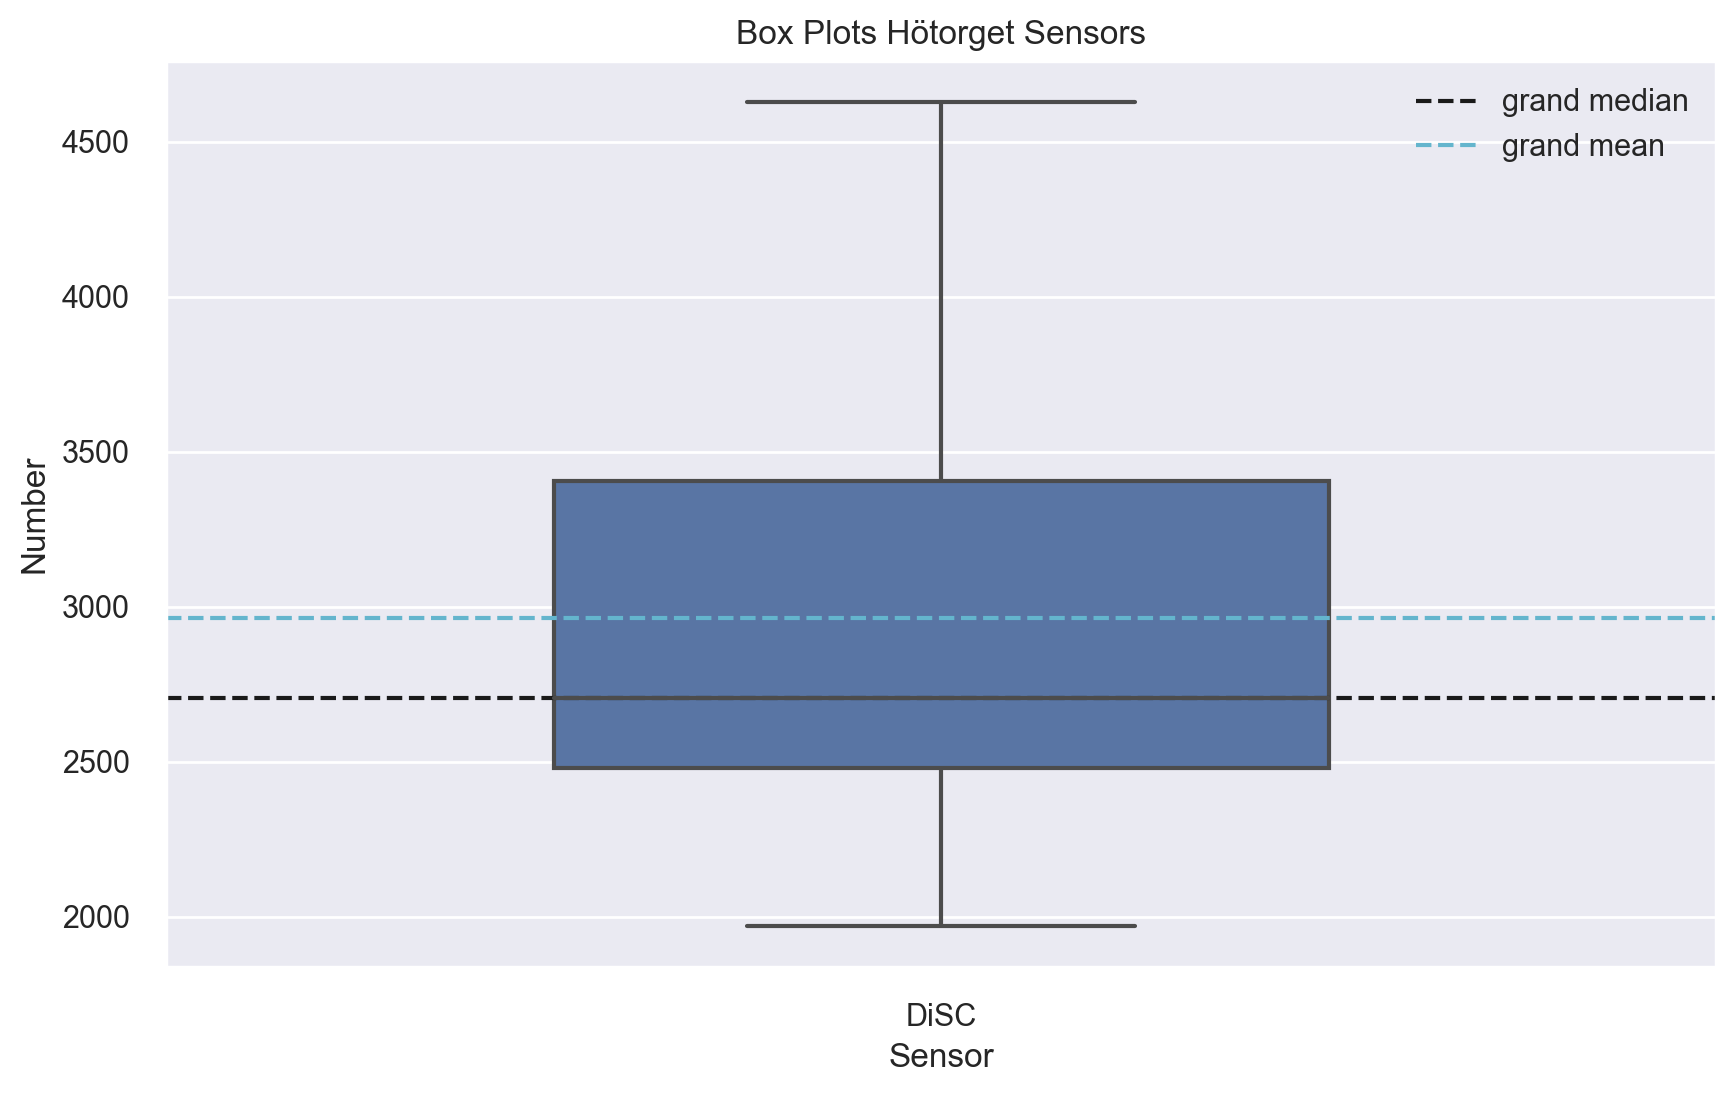

In [38]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Hötorget Sensors')
plt.savefig(f'{fig_folder}/Hötorget_box_plot_sensor({param}).pdf')
plt.show()

In [39]:
station_diffs['Hötorget']

[173.87355056607305,
 492.88398454628475,
 196.68660108817542,
 81.95875850229855,
 338.2310130396356,
 123.86637607066382,
 167.56334978292892,
 166.53592491025557,
 195.98299245937983,
 360.6875379050405,
 212.952886381429,
 174.31939077452057]

In [40]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

Number                                                    \
            Q1    Q2      Q3  IQR lowerLimit upperLimit outliers   
Sensor                                                             
DiSC    2479.5  2704  3404.5  925       1092       4792        0   

                             
       prcnt_outliers count  
Sensor                       
DiSC                0   135

### Box plot sessions

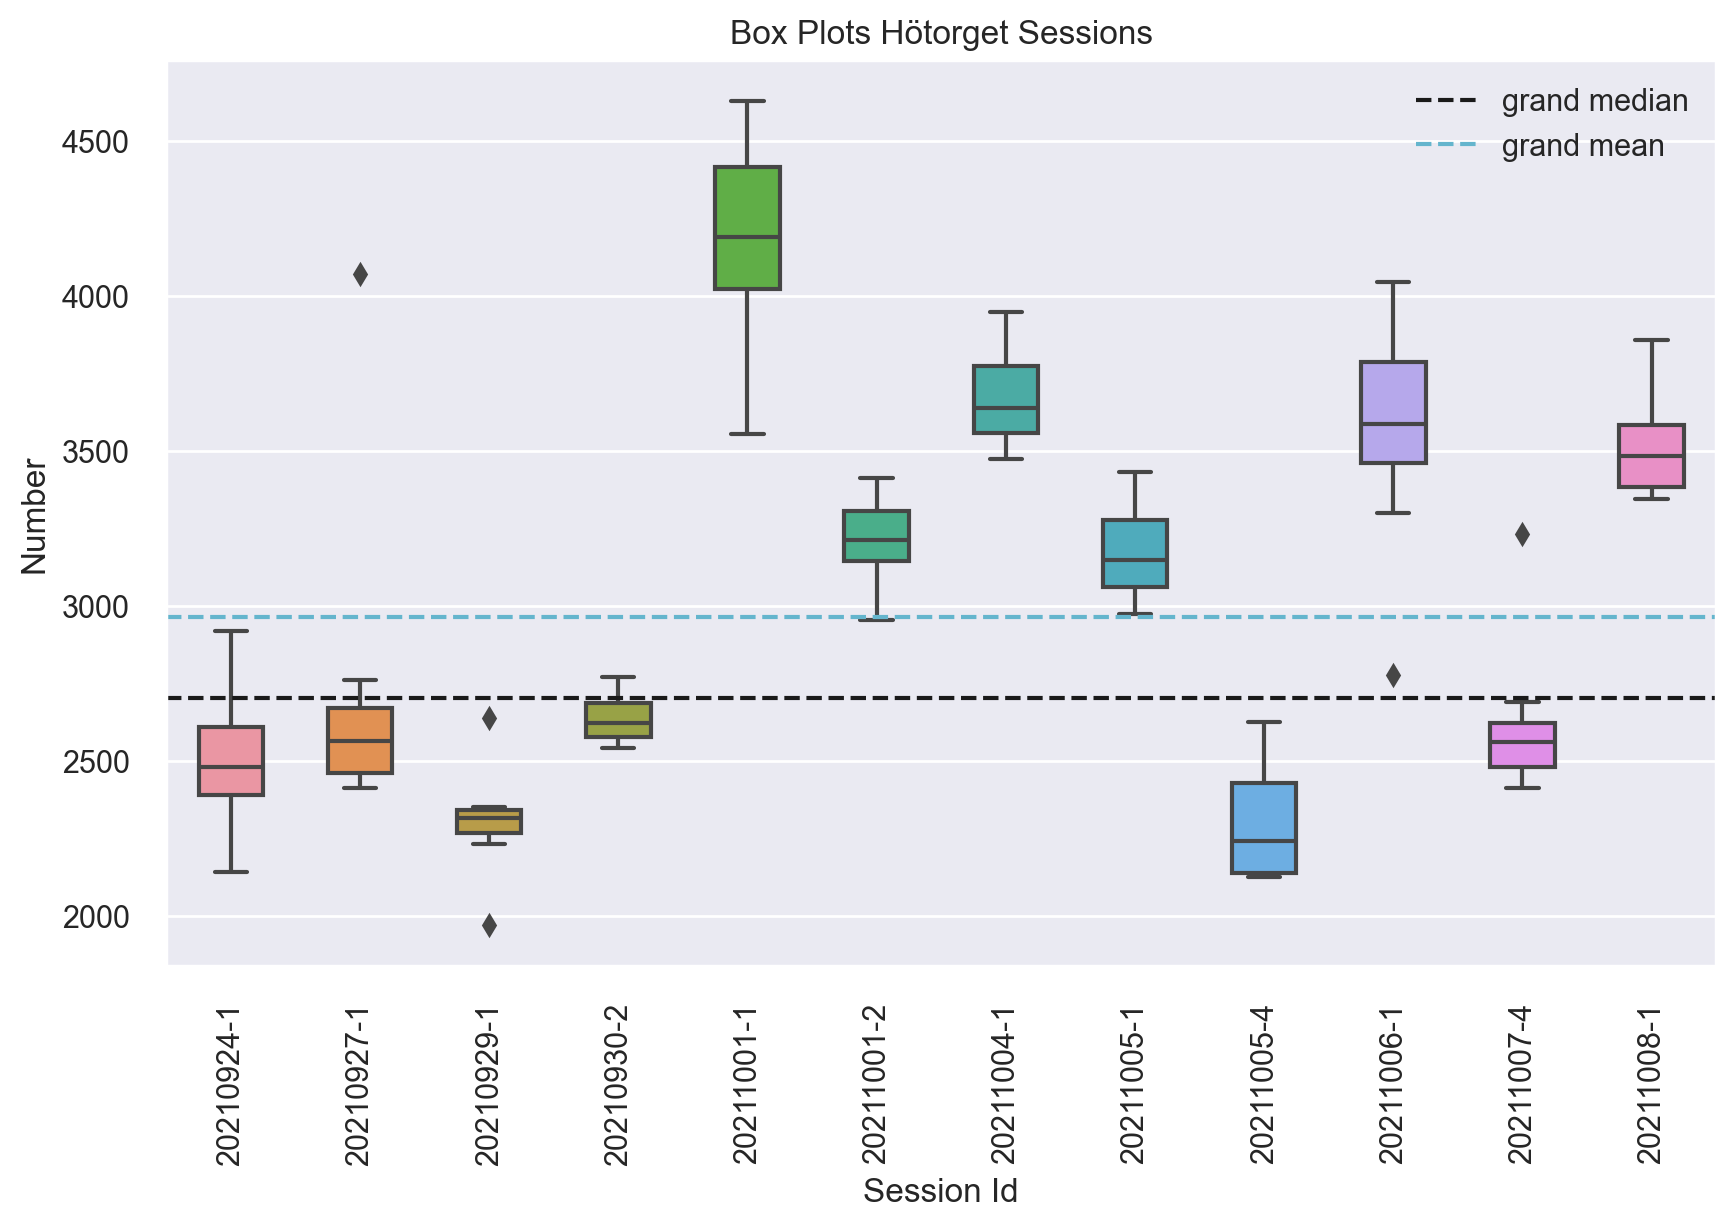

In [41]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Hötorget Sessions')
plt.savefig(f'{fig_folder}/Hötorget_box_plot_sessions({param}).pdf')
plt.show()

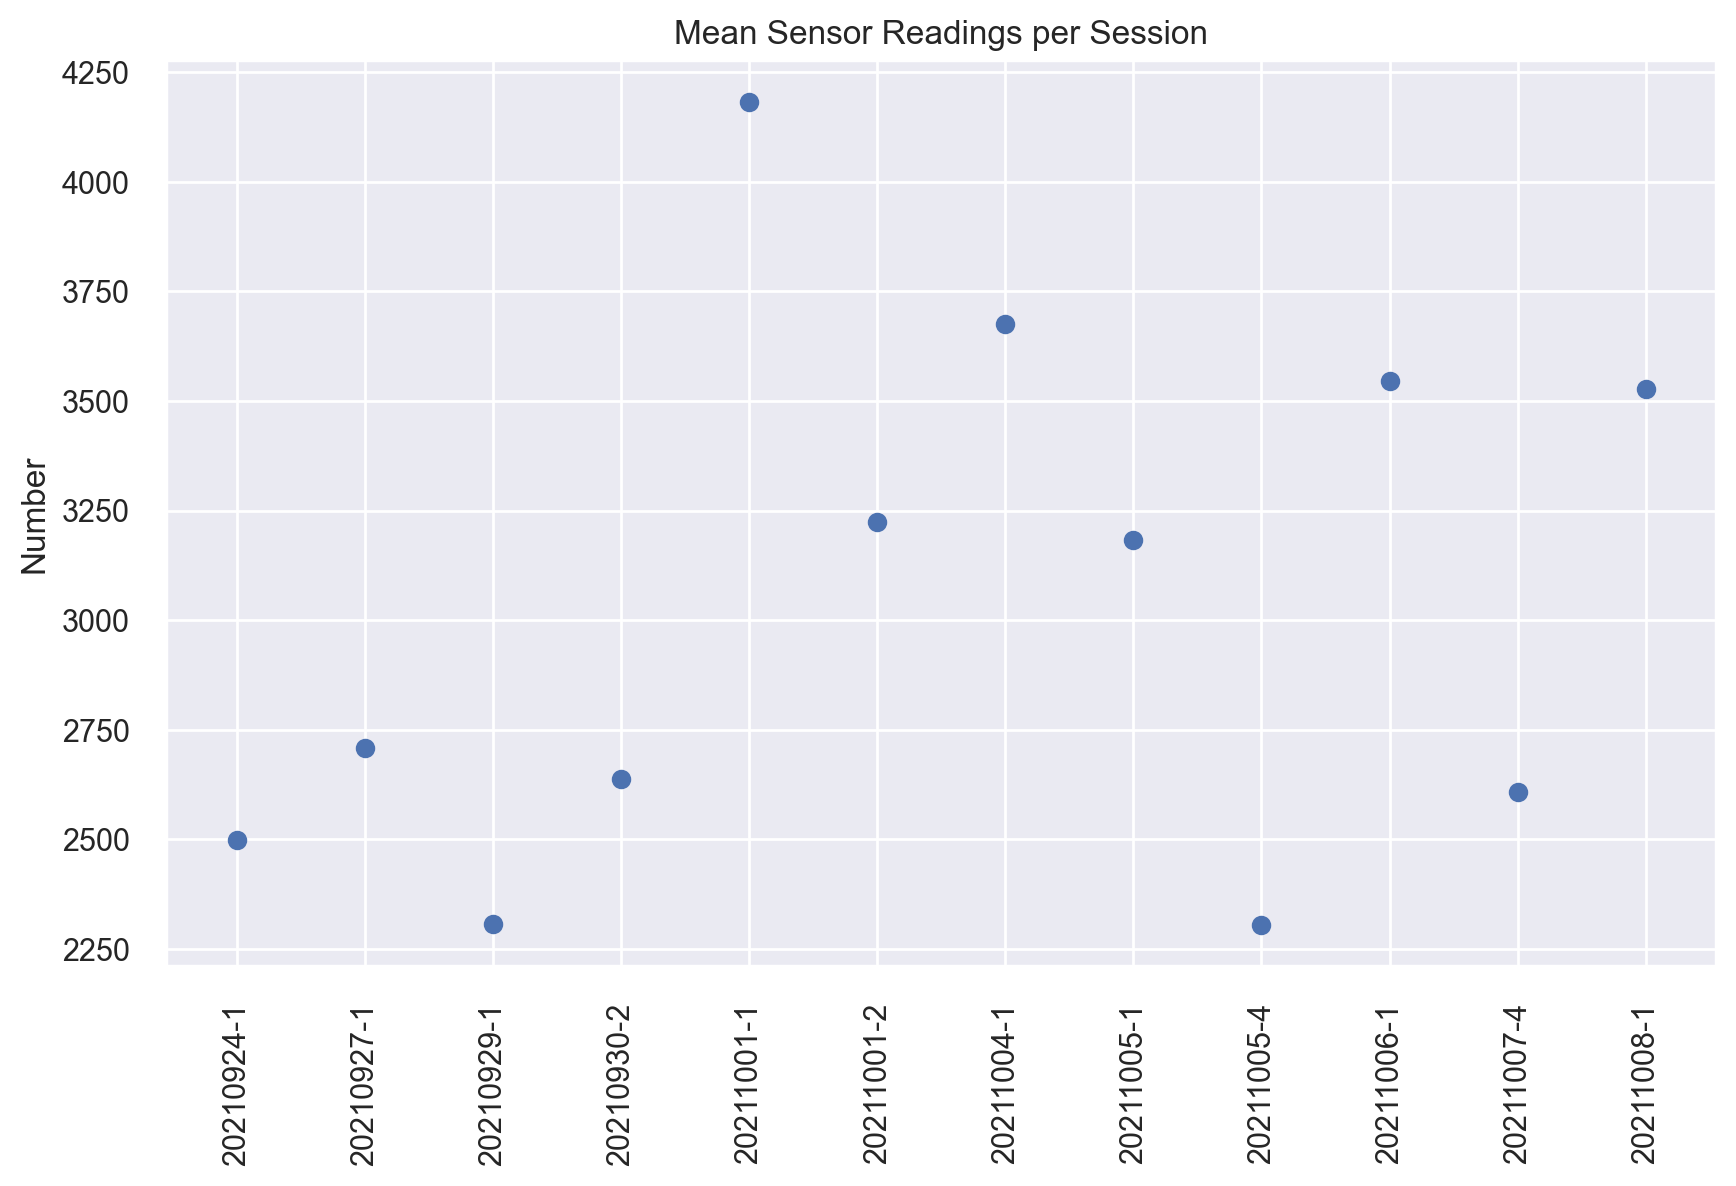

In [42]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

session_sensors = {}
for sensor, grp in focus_r_df.groupby('Sensor'):
    if sensor not in session_sensors:
        session_sensors[sensor] = {}
        
    for session_id, session_grp in grp.groupby('Session Id'):
        session_sensors[sensor][session_id] = session_grp[param].mean()
        
for sensor, data in session_sensors.items():
    ax.scatter(data.keys(), data.values(), label=sensor)
    
plt.xticks(rotation=90)
#plt.legend()
plt.title('Mean Sensor Readings per Session')
plt.savefig(f'{fig_folder}/Hötorget_mean_sensor_reading_per_session({param}).pdf')
plt.ylabel(param)

plt.show()

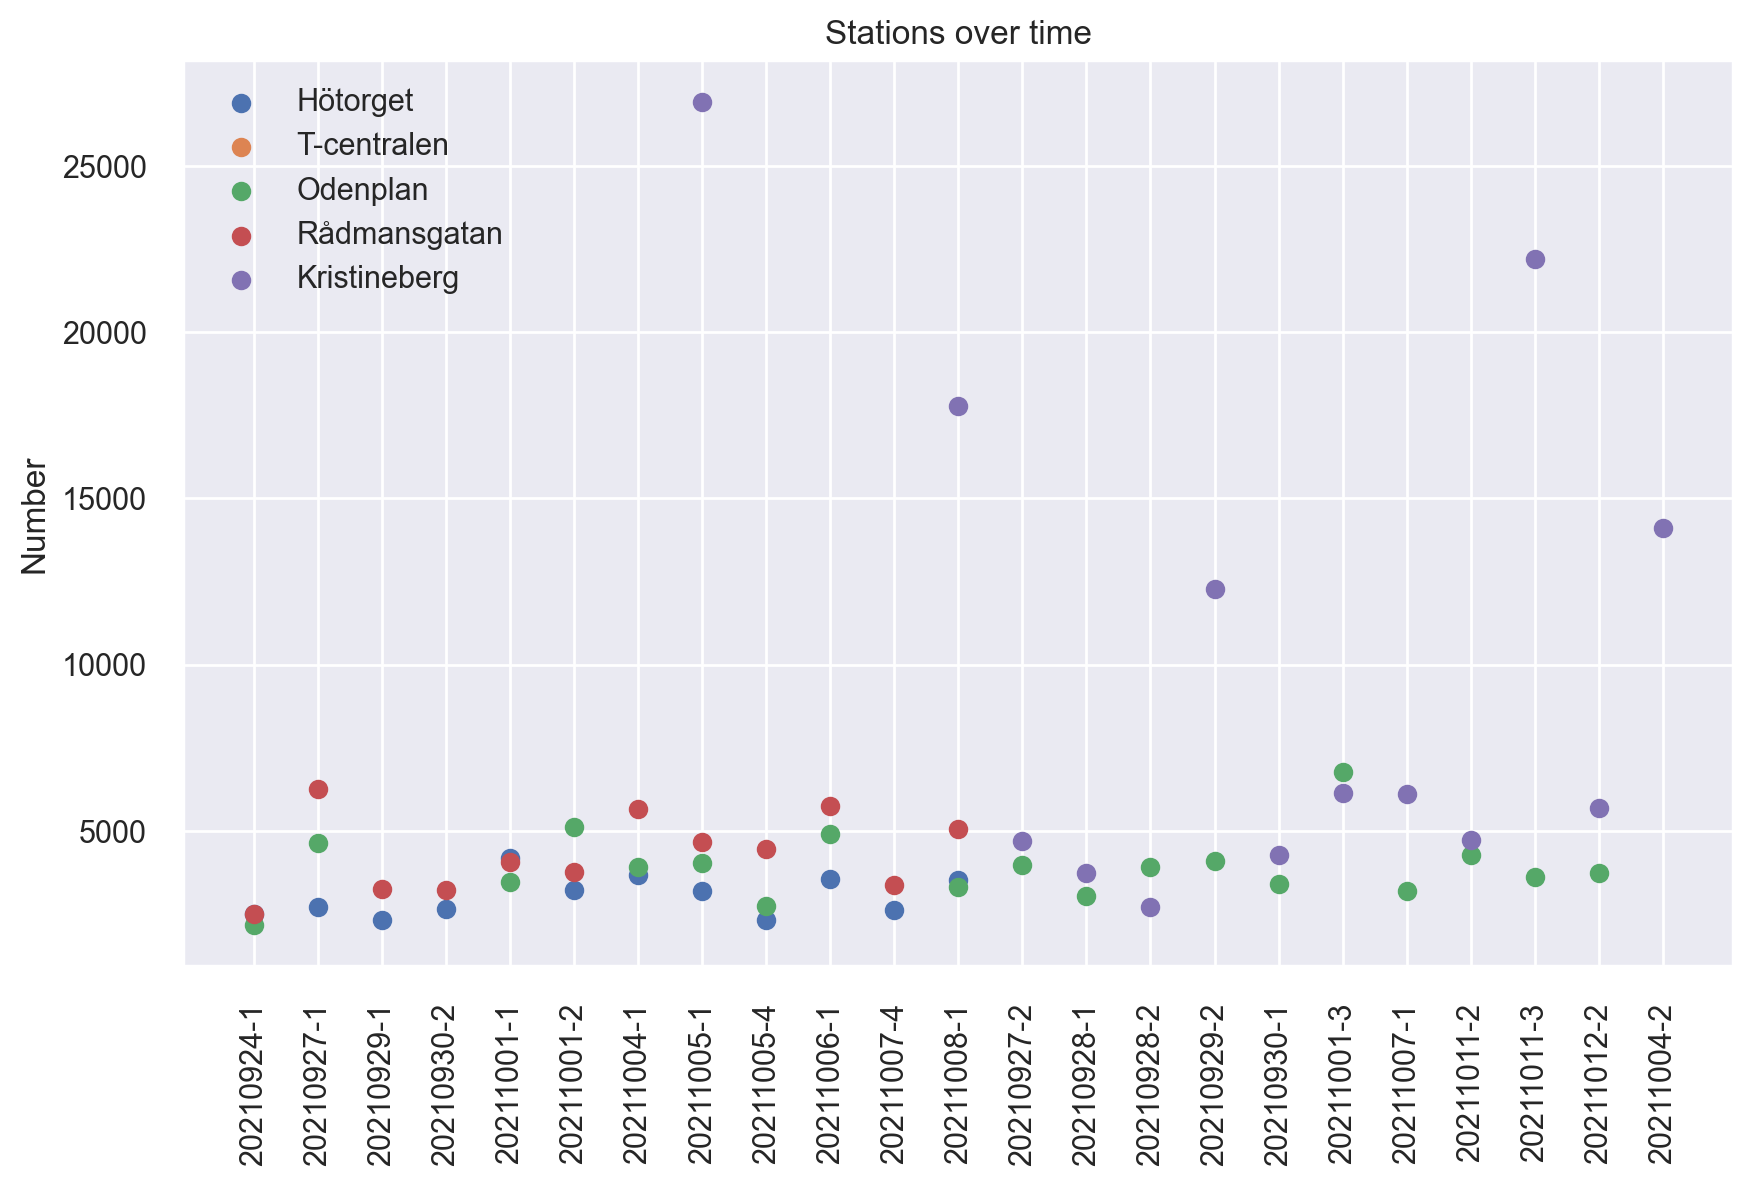

In [43]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

for station in ['Hötorget', 'T-centralen', 'Odenplan', 'Rådmansgatan', 'Kristineberg']:
    session_means = {}
    for session, grp in r_df[r_df['Station'] == station].groupby('Session Id'):
        session_means[session] = grp[param].mean()

    ax.scatter(session_means.keys(), session_means.values(), label=station)
    
plt.xticks(rotation=90)
plt.legend()
#plt.legend()
plt.title('Stations over time')
plt.savefig(f'{fig_folder}/focus_dfs_over_time({param}).pdf')
plt.ylabel(param)

plt.show()

### Distribution

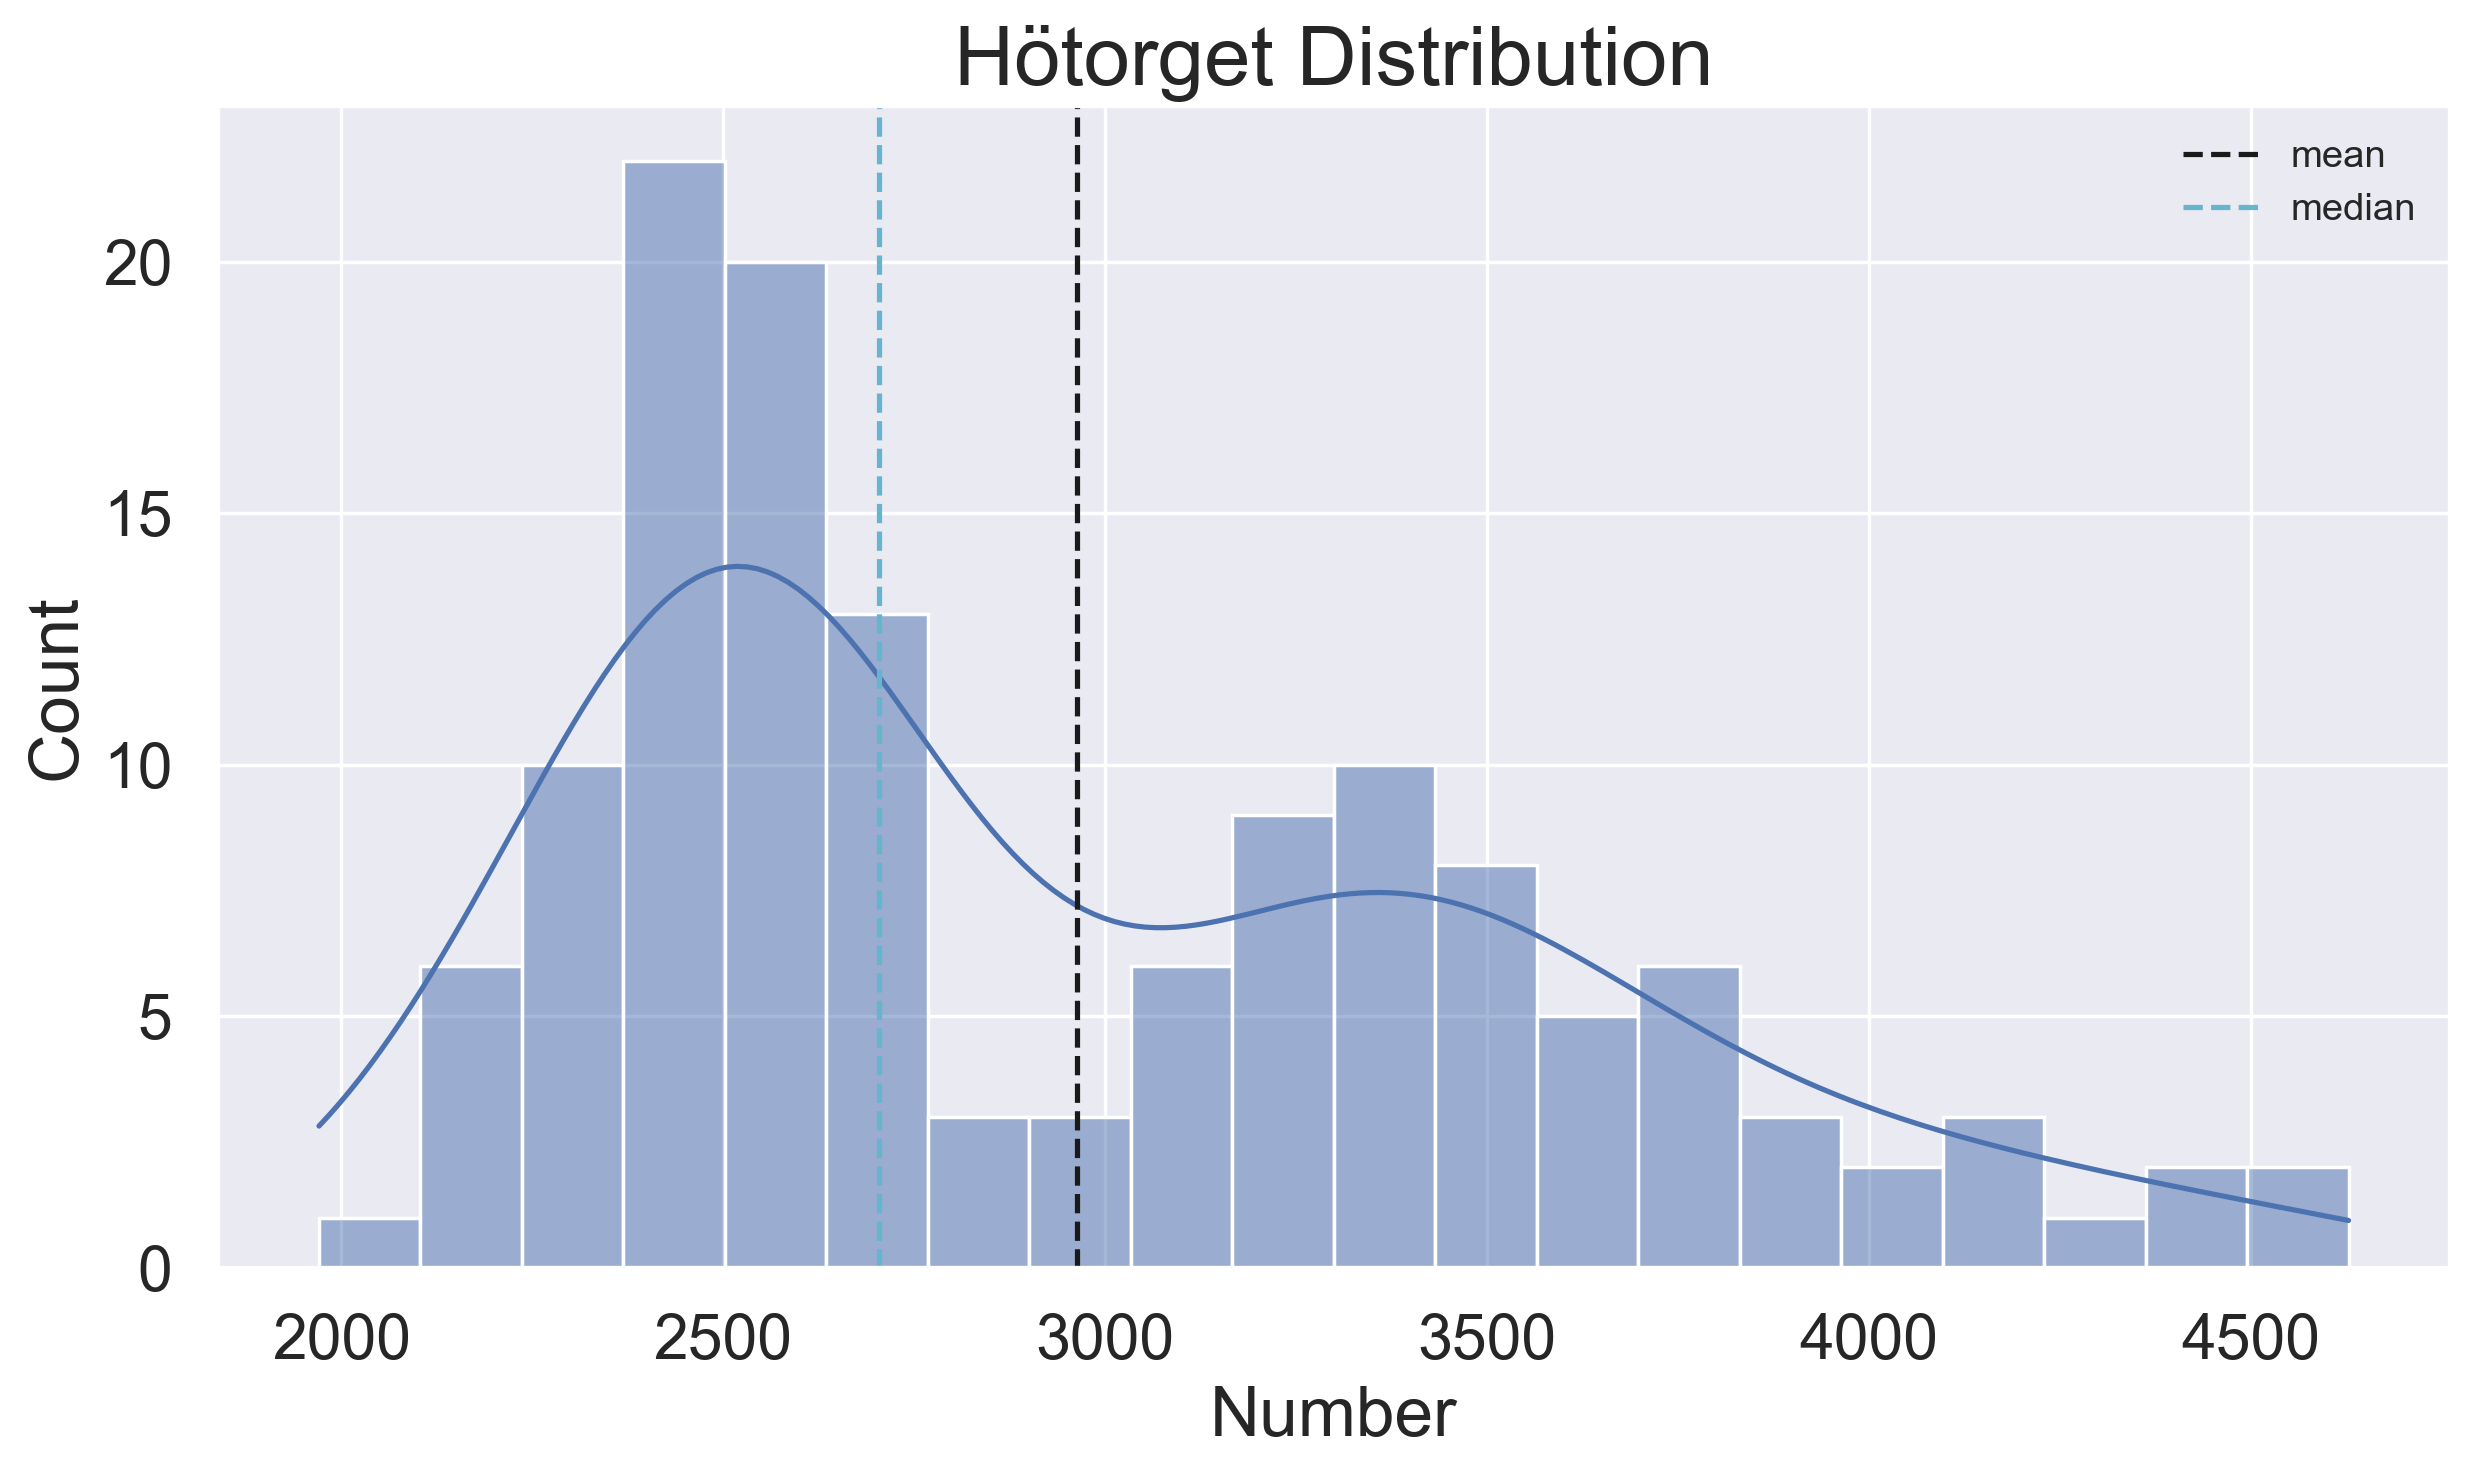

In [44]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=20)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Hötorget Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/HötorgetDistribution({param}).pdf')

plt.show()

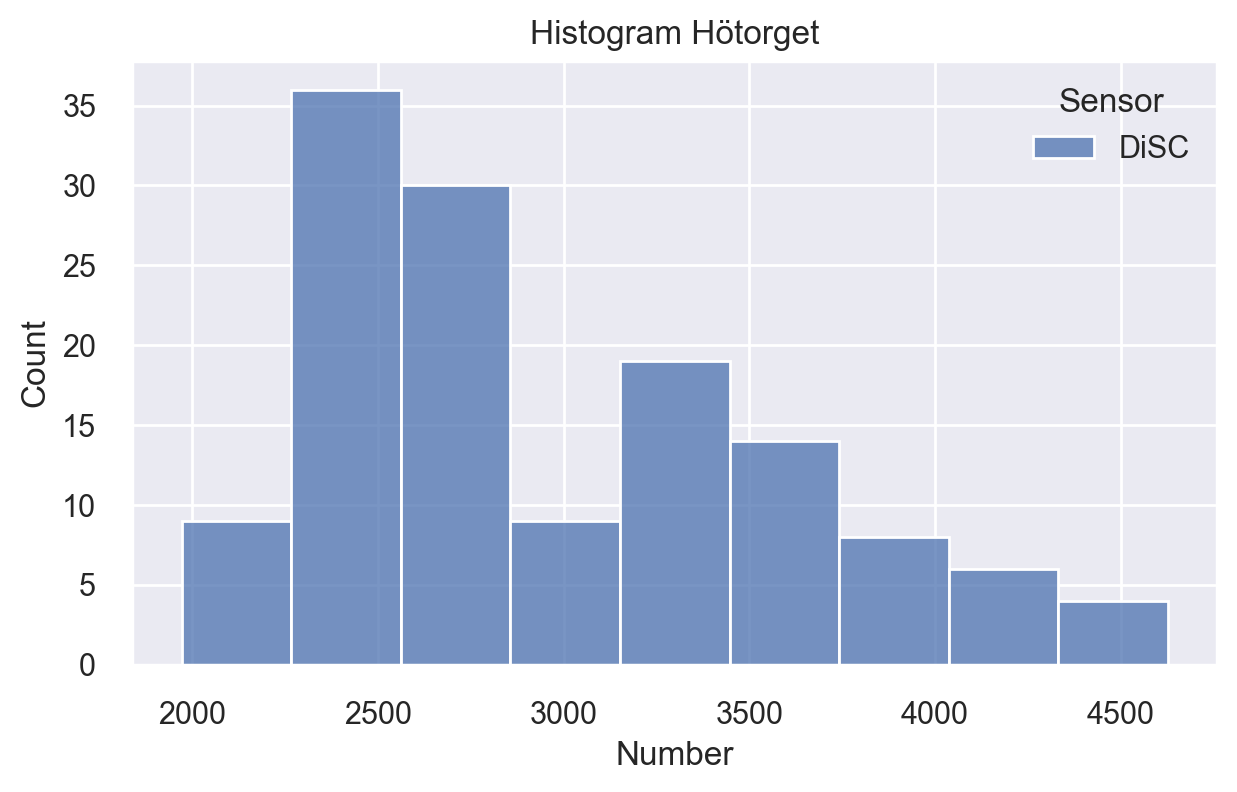

In [45]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HötorgetHistogram1Sensor({param}).pdf')

plt.show()

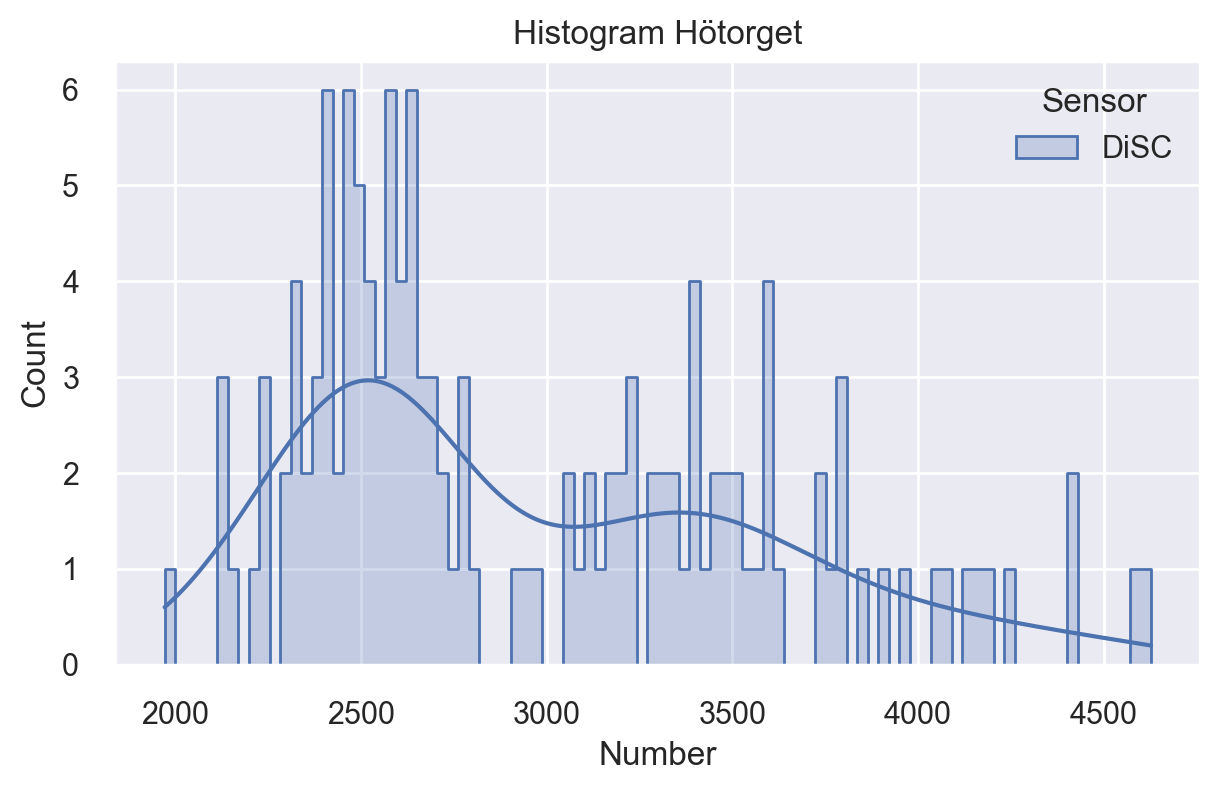

In [46]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HötorgetDistribution2Sensor({param}).pdf')

plt.show()

# Size distributions

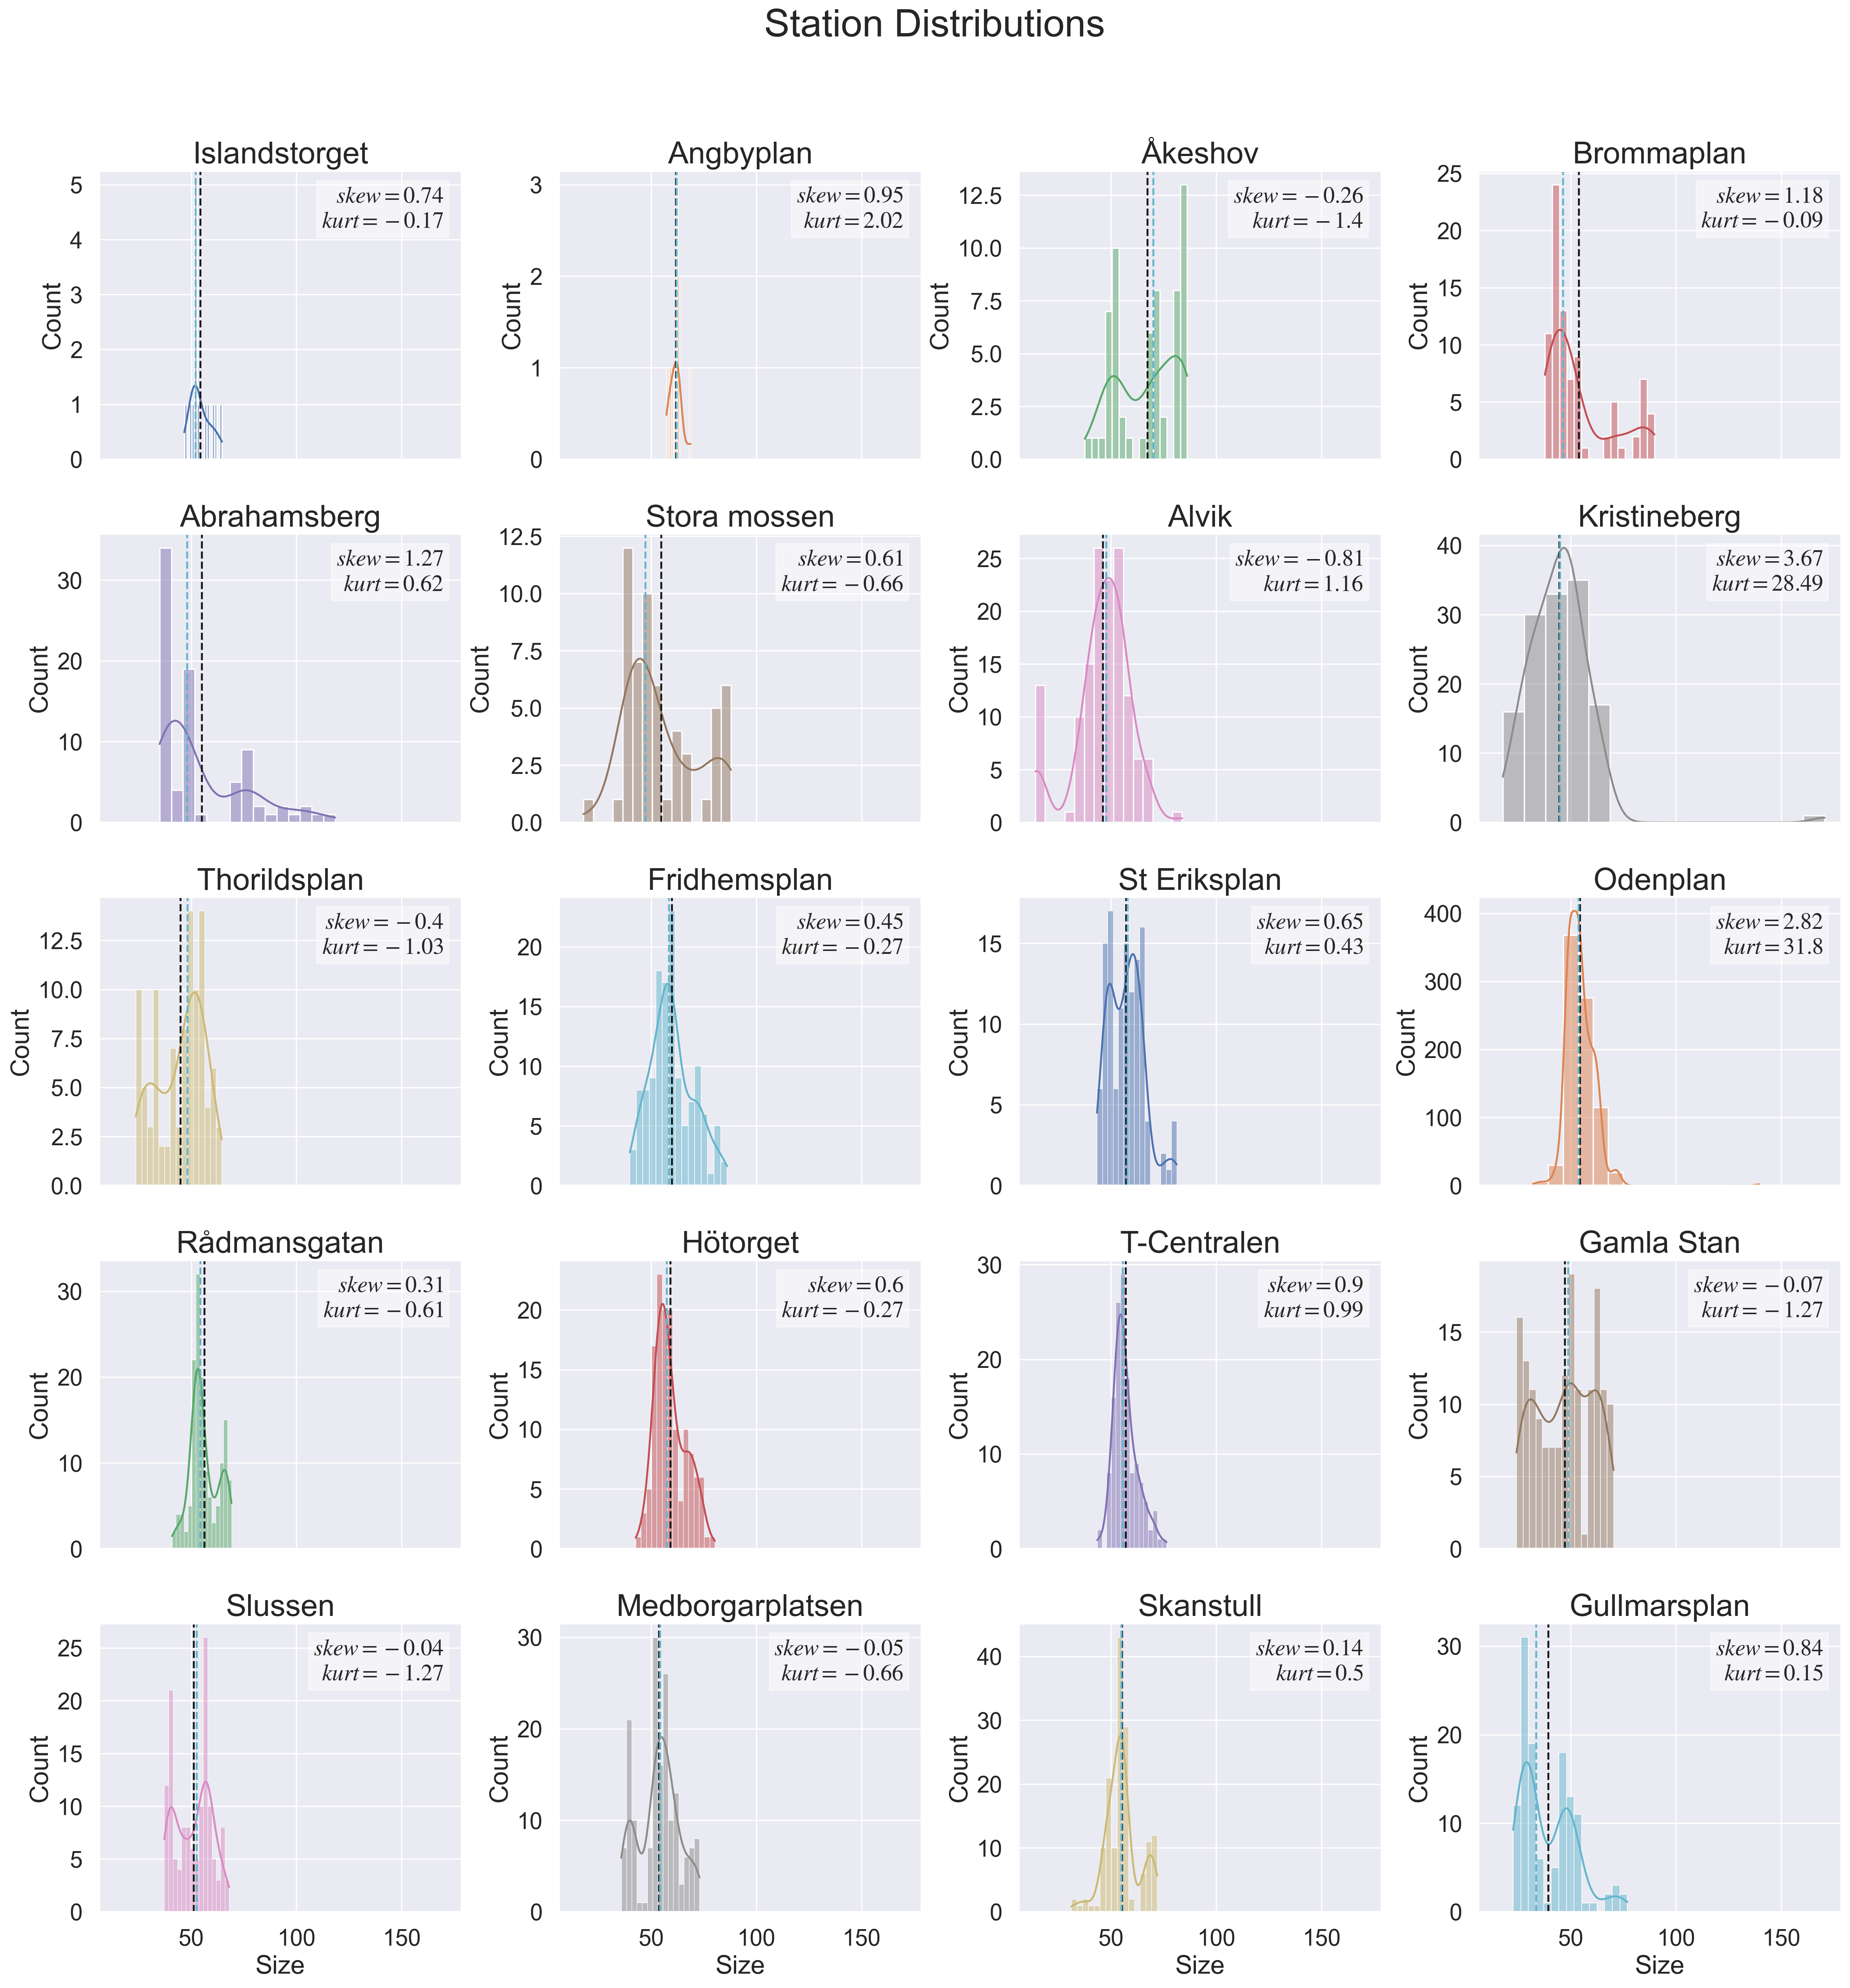

In [47]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/size_distribution({param}).pdf',
    param='Size',
    with_textbox=True,
    column_count=4,
    bins=15,
    share_x=True,
    share_y=False
)

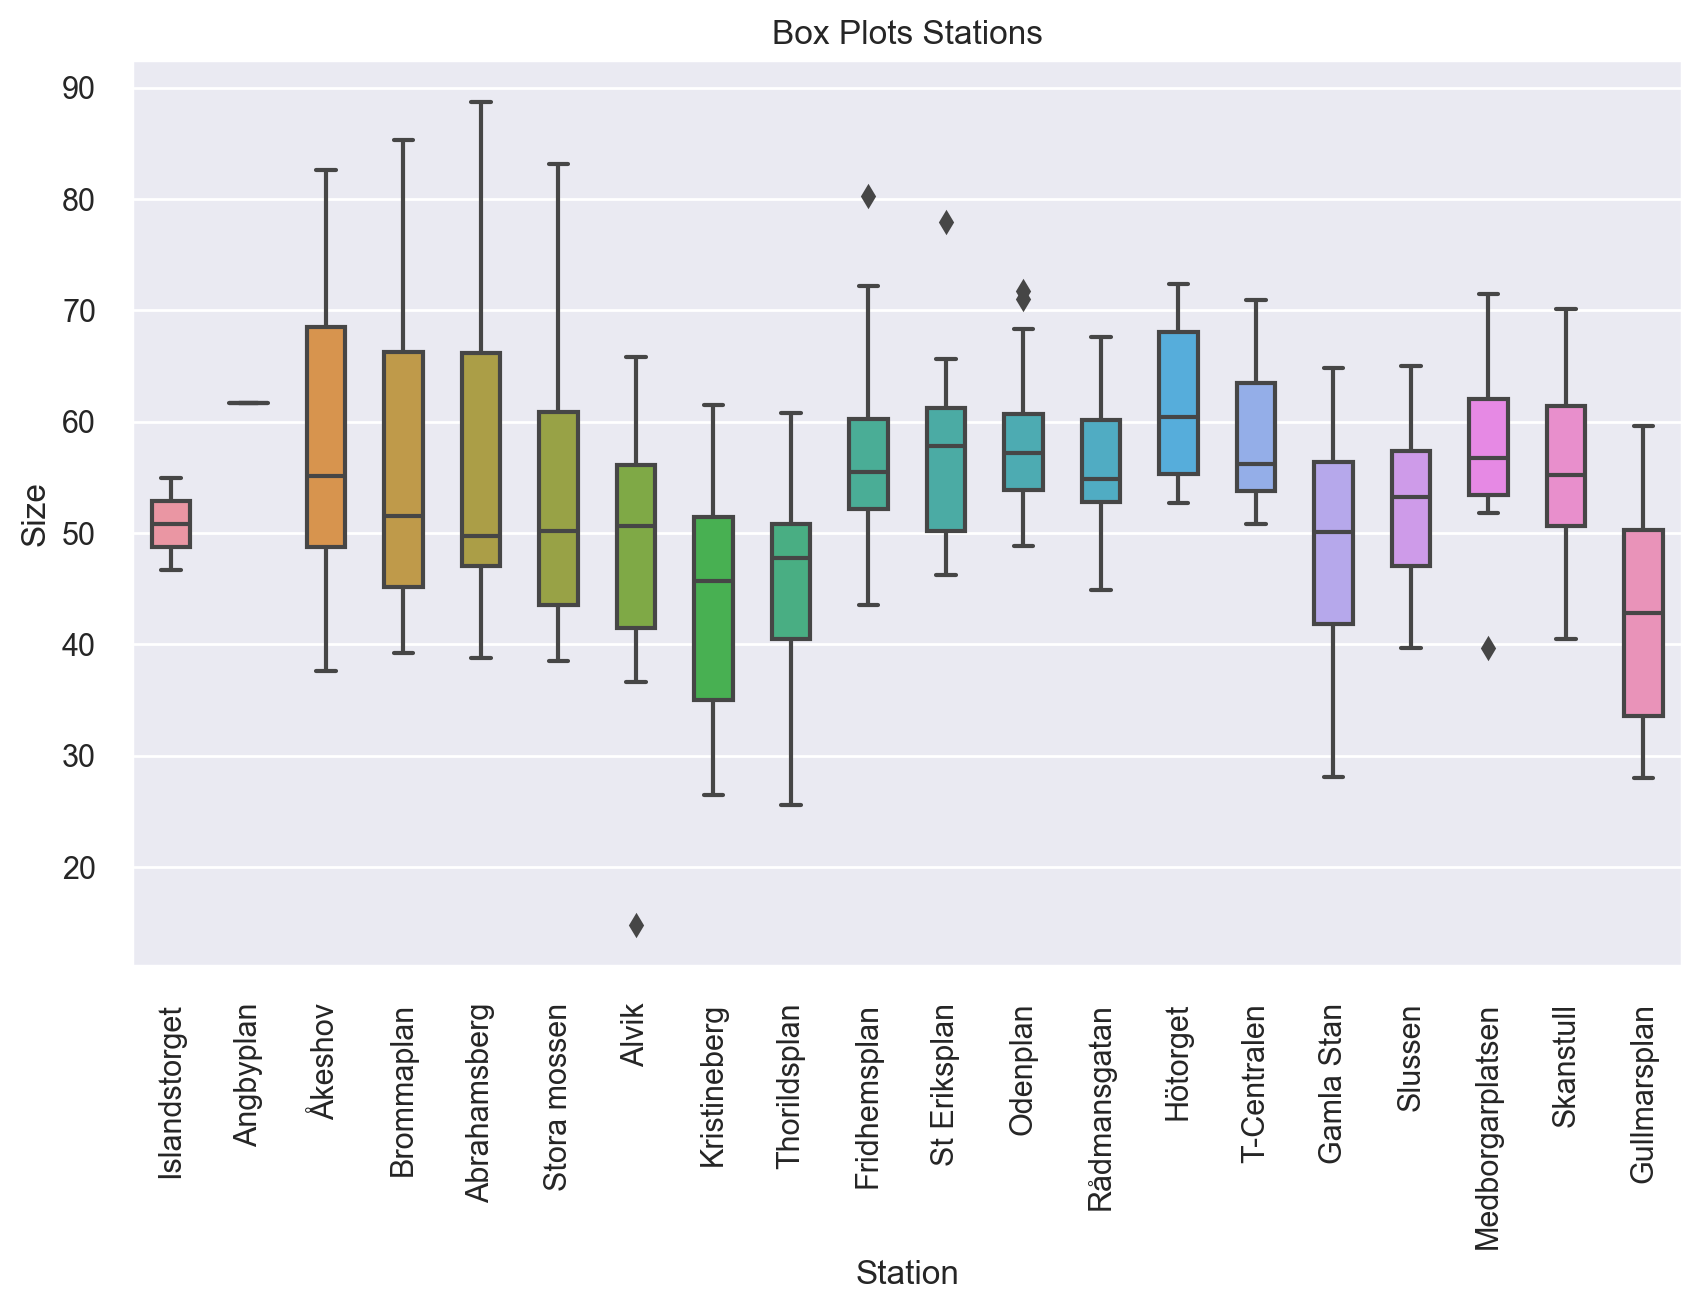

In [49]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y='Size', data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots(Size).pdf')

plt.show()

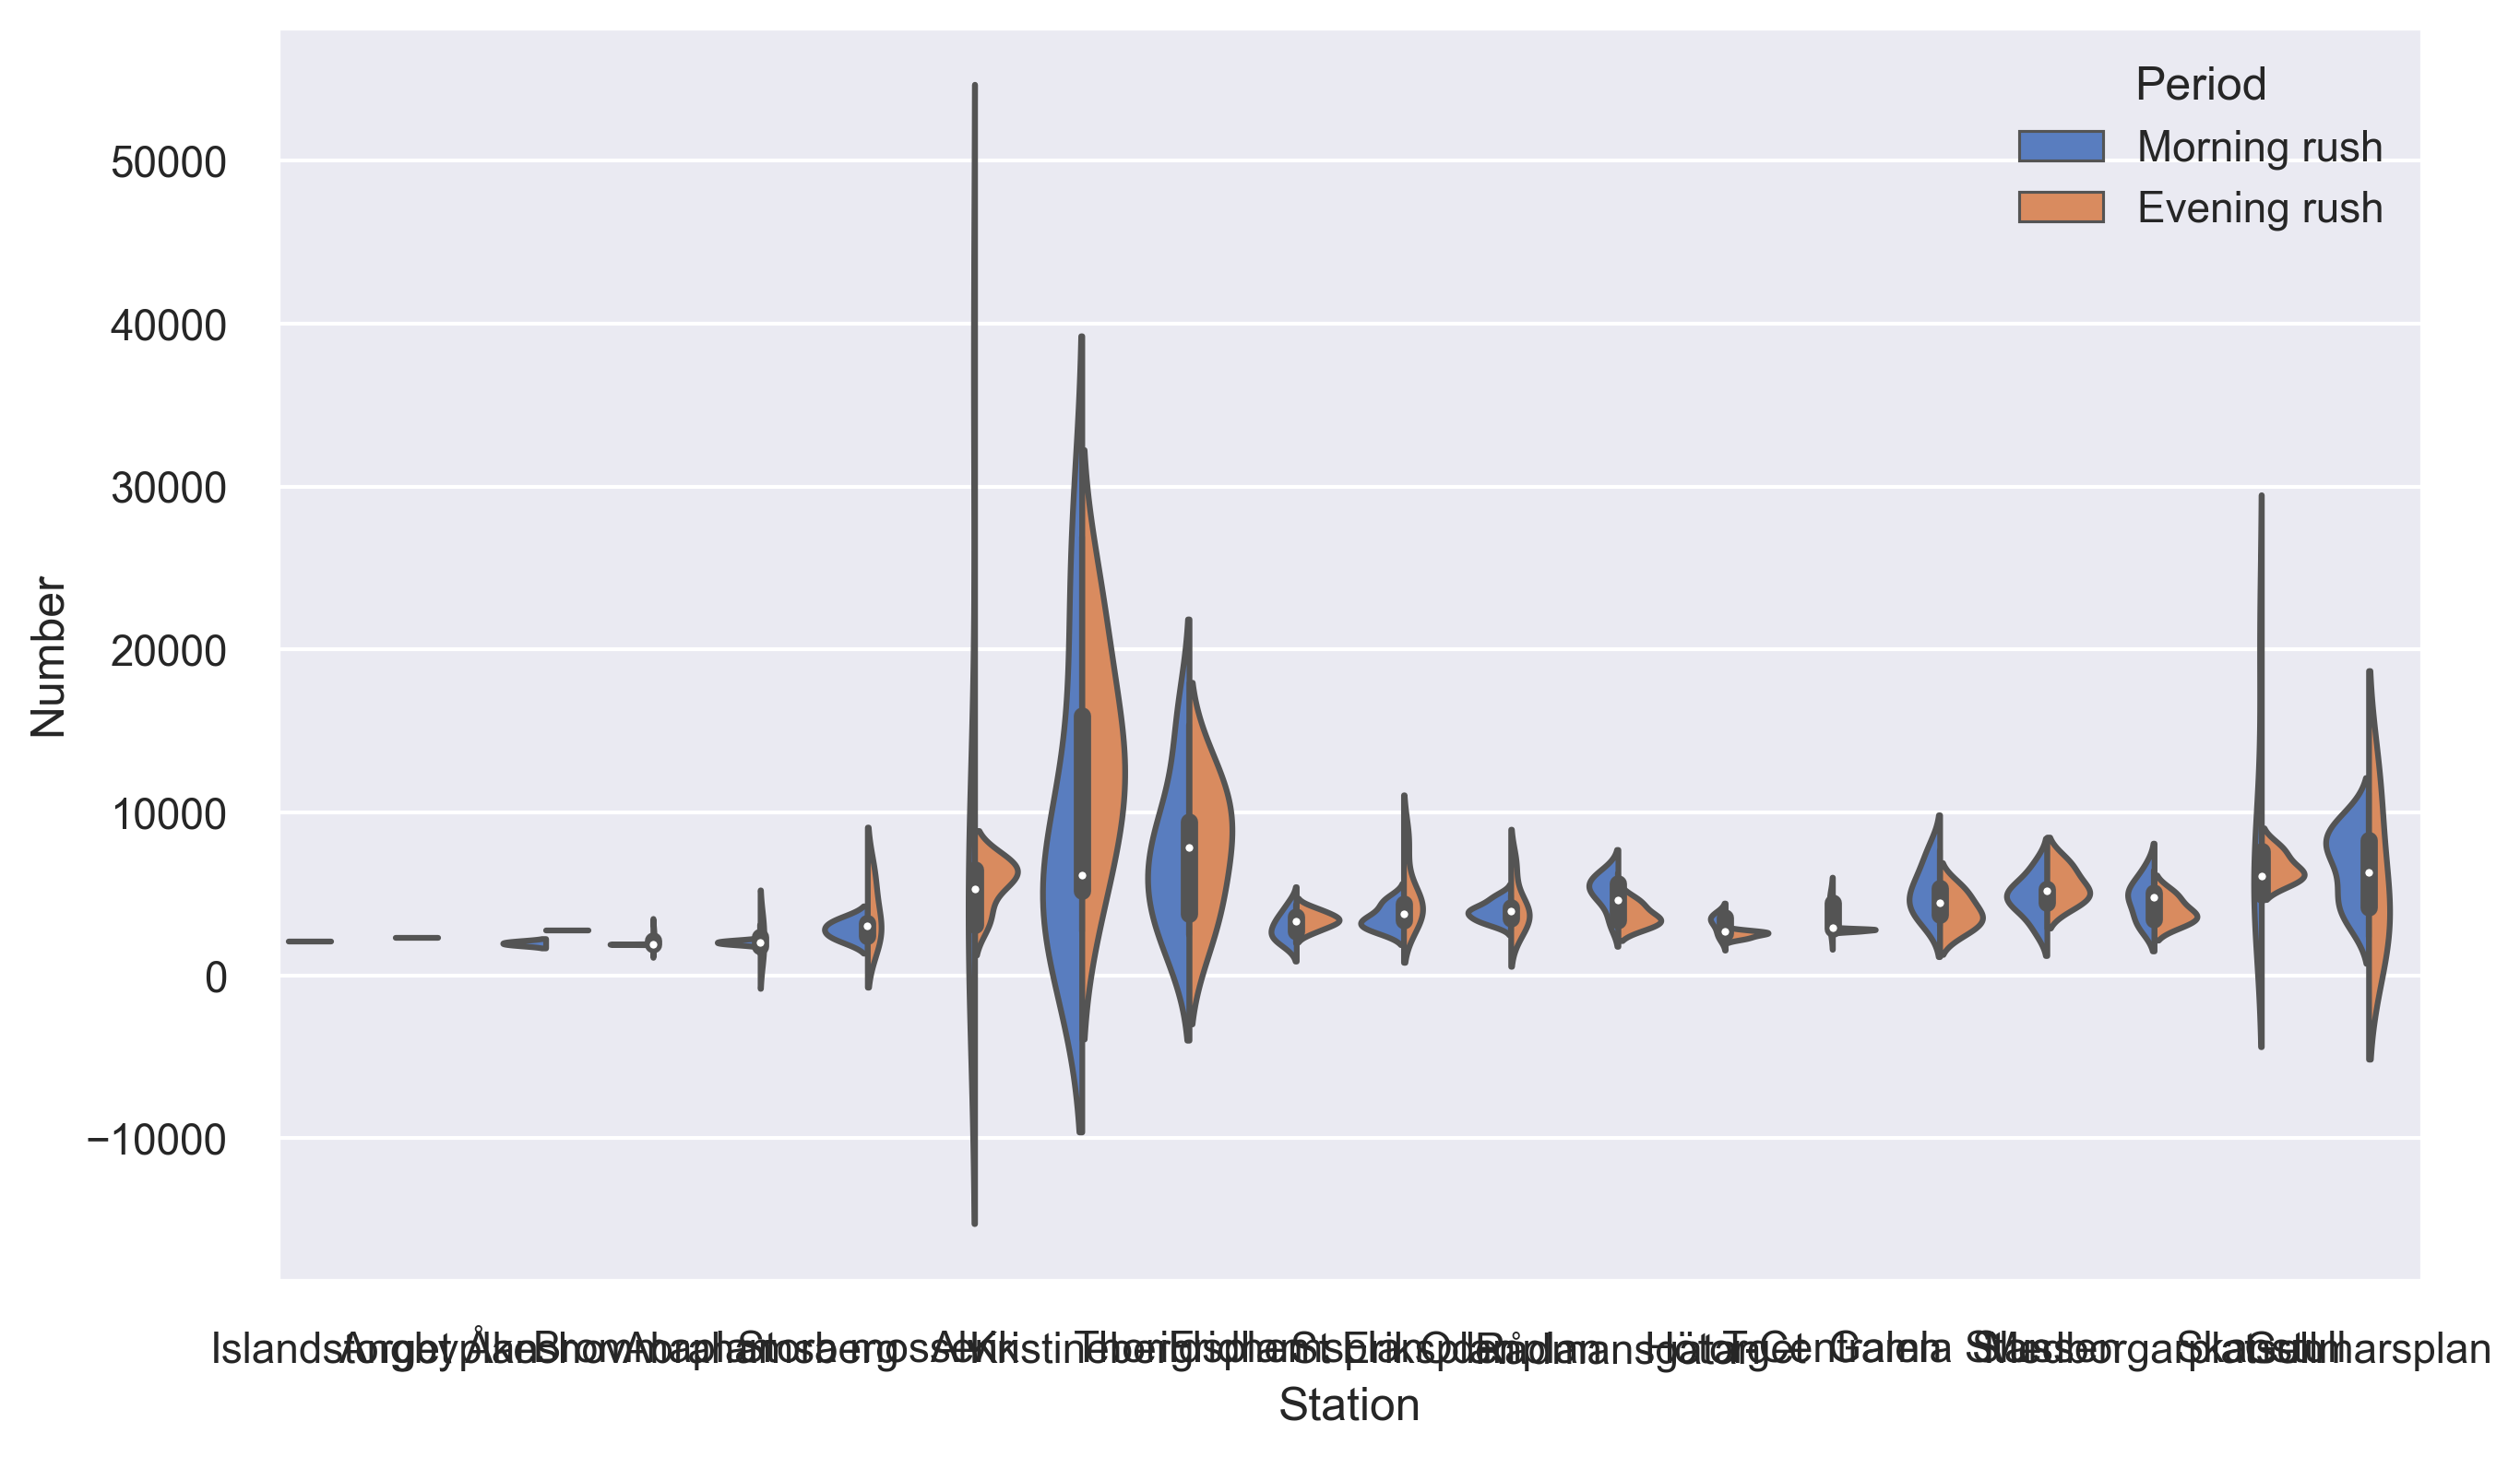

In [57]:
plot_df = s_df[s_df['Period'].isin(['Morning rush', 'Evening rush'])]

fig, ax = plt.subplots(figsize=[10, 6], dpi=300)

ax = sns.violinplot(x="Station", y="Number", hue='Period',
                    data=plot_df, palette="muted", split=True)